In [1]:
#try upscaling data twice and see if it changes the results
#try downscaling as well

import numpy as np
from aicsimageio import AICSImage
from tkinter import filedialog
import napari
import os
from PyQt5.QtWidgets import QApplication, QMessageBox
from qtpy.QtCore import QEventLoop
from magicgui import magicgui
from skimage import io, transform
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy.signal import find_peaks
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import xml.etree.ElementTree as ET
import matplotlib.patches as mpatches

from scipy.optimize import curve_fit





In [19]:
def file_import():
    #file_path = r"C:\Users\champ\Documents\Master_Thesis_CSI\data\images\250131_GPMVs_RPE-1_4mM-DTT_Media_25nM-NR12A-HBSS\250131_GPMVs_RPE-1_4mM-DTT_HBSS_500nM-NR12S-HBSS_stack_02_BP570-610_LP655-Channel Alignment-35-Lattice Lightsheet-57.czi"
    file_path = filedialog.askopenfilename(title="Select a CZI File", filetypes=[("CZI files", "*.czi")])

    channel_names = []
    channel_emission = []

    if not file_path:
        print("No file selected.")
        return None, None, None, None

    root = os.path.dirname(file_path)
    filename = os.path.splitext(os.path.basename(file_path))[0]

    img = AICSImage(file_path)

    # Convert to numpy array
    data = img.get_image_data()  # Adjust dimensions as needed
    data = np.squeeze(data)  # Remove single-dimensional entries

    # Extract metadata XML
    metadata_xml = img.metadata

    for channel in metadata_xml.findall(".//Dimensions/Channels/Channel"):
        # Get channel name
        name = channel.get("Name")
        if name:
            channel_names.append(name)
        
        # Get emission wavelength (if available)
        emission = channel.find(".//EmissionWavelength")
        if emission is not None and emission.text:
            channel_emission.append(float(emission.text))
        else:
            channel_emission.append(None)
    

    return root, filename, data, channel_names, channel_emission

def select_pixel_radius(polar_image):
    # Get the minimum between the x and y axis
    max_value = np.min(polar_image.shape[1:], axis=0)
    event_loop = QEventLoop()  # Create an event loop
    viewer = napari.Viewer()
    viewer.add_image(polar_image, name="Polar Image", colormap='gray')

    #
    # Add an image layer for the radius (circle) on top of the image
    radius_layer = viewer.add_image(
        data=np.zeros_like(polar_image), name="Radius", colormap='yellow', blending='additive', opacity=0.25
    )

    selection_params = {"pixel": None, "radius": None}  # Default radius

    def update_selection(radius: float, x: int, y: int):
        selection_params["radius"] = radius
        selection_params["pixel"] = (y, x)

        # Create a circle mask for the selected radius
        r = selection_params["radius"]
        y, x = selection_params["pixel"]
        
        # Create a circular mask for visualization
        y_grid, x_grid = np.ogrid[:polar_image.shape[1], :polar_image.shape[2]]
        mask = (y_grid - y)**2 + (x_grid - x)**2 <= r**2
        radius_layer.data = np.broadcast_to(mask.astype(float), polar_image.shape)
        
    @magicgui(
        radius={"label": "Radius", "widget_type": "SpinBox", "min": 1, "max": max_value, "step": 5, "value": int(max_value / 10)},
        x={"label": "X", "widget_type": "SpinBox", "min": 0, "max": polar_image.shape[2], "step": 1, "value": 0},
        y={"label": "Y", "widget_type": "SpinBox", "min": 0, "max": polar_image.shape[1], "step": 1, "value": 0}
    )
    def selection_widget(radius: float, x: int, y: int):
        # Call the update_selection function whenever a slider value changes
        update_selection(radius, x, y)
        selection_params["radius"] = radius
        selection_params["pixel"] = (y, x)
        event_loop.quit()  # Stop blocking execution



    # Connect the change event for all three widgets (radius, x, y) to the update function
    for widget in [selection_widget.radius, selection_widget.x, selection_widget.y]:
        widget.changed.connect(lambda: update_selection(selection_widget.radius.value, selection_widget.x.value, selection_widget.y.value))

    # Close event: Quit event loop if user closes Napari manually
    def on_close(event):
        if event_loop.isRunning():
            selection_params["pixel"] = None
            selection_params["radius"] = None
            event_loop.quit()

    viewer.window._qt_window.closeEvent = on_close  # Capture close event

    viewer.window.add_dock_widget(selection_widget, area="right")

    event_loop.exec_() 
    viewer.close()

    if selection_params["pixel"] is None or selection_params["radius"] is None:
        print("Object selection cancelled or invalid.")
        return None, None

    return selection_params["pixel"], selection_params["radius"]
#select the threshold for the polar image -> not currently used
def select_threshold_polar_image(polar_image):
    max_value = np.max(polar_image)
    viewer = napari.Viewer()
    viewer.add_image(polar_image, name="Polar Image", blending='translucent', opacity=0.5, colormap='grey')
    viewer.add_image(np.zeros_like(polar_image), name="Mask", blending='translucent', opacity=0.5, colormap='green')
    event_loop = QEventLoop()  # Create an event loop
    threshold_parameters = {"threshold_mode": None, "threshold_value": None}

    @magicgui(
            threshold_mode={"label": "Threshold Mode", "choices": [None, "Manual", "Otsu"]},
            threshold_value={"label": "Threshold Value", "widget_type": "FloatSpinBox", "min": 0, "max": max_value, "step": max_value/100, "value": max_value/2, "visible": False},
            call_button="Run"
    )
    def parameter_selector(threshold_mode: str, threshold_value: float):
        if threshold_mode is None:
            msg = QMessageBox()
            msg.setIcon(QMessageBox.Warning)
            msg.setText("Please choose a threshold mode.")
            msg.setWindowTitle("Threshold Selection Error")
            msg.exec_()
            return
        threshold_parameters["threshold_mode"] = threshold_mode
        threshold_parameters["threshold_value"] = threshold_value
        event_loop.quit()  # Stop blocking execution

    @parameter_selector.threshold_mode.changed.connect
    def _on_mode_change(value: str):
        parameter_selector.threshold_value.visible = (value == "Manual")
        parameter_selector.threshold_value.parent.update()
        update_mask(value)

    @parameter_selector.threshold_value.changed.connect
    def _on_threshold_change(value: float):
        if parameter_selector.threshold_mode.value == "Manual":
            update_mask("Manual")

    def update_mask(mode):
        if mode == "Otsu":
            threshold = threshold_otsu(polar_image[polar_image > 0])
        else:
            threshold = parameter_selector.threshold_value.value

        mask = polar_image > threshold
        if "Mask" in viewer.layers:
            viewer.layers["Mask"].data = mask

    def on_close(event):
        if event_loop.isRunning():
            threshold_parameters["threshold_mode"] = None
            threshold_parameters["threshold_value"] = None
            event_loop.quit()

    # **Fix: Capture close event using Qt window's closeEvent**
    viewer.window._qt_window.closeEvent = on_close

    # **Fix: Explicitly add magicgui as a dock widget**
    viewer.window.add_dock_widget(parameter_selector, area="right")

    # **Fix: Allow time for UI to render before starting the event loop**
    viewer.window._qt_window.show()
    event_loop.exec_()

    # Make sure the viewer is closed before proceeding
    viewer.close()  # Close the viewer here after the event loop ends

    if threshold_parameters["threshold_mode"] == "Manual":
        threshold_parameters["threshold_value"] = threshold_parameters["threshold_value"]
    elif threshold_parameters["threshold_mode"] == "Otsu":
        threshold_parameters["threshold_value"] = threshold_otsu(polar_image[polar_image > 0])

    return threshold_parameters["threshold_value"]

def sin_func(x, A, f, phi, offset):
    return A * np.sin(2 * np.pi * f * x + phi) + offset

def find_dominant_frequency(x, y, power_threshold=0.05):
    # Replace NaNs with 0
    y = np.nan_to_num(y)
    
    # Compute FFT
    ff = np.fft.fftfreq(len(x), d=(x[1] - x[0]))  # Frequency values
    Fy = np.abs(np.fft.fft(y))  # FFT magnitude
    
    # Exclude DC component (zero frequency)
    Fy[0] = 0  
    
    # Compute power threshold (e.g., 5% of max amplitude)
    threshold = power_threshold * np.max(Fy)
    
    # Filter frequencies based on threshold
    significant_frequencies = ff[Fy > threshold]
    significant_amplitudes = Fy[Fy > threshold]
    
    if len(significant_frequencies) == 0:
        print("No significant frequency found above threshold.")
        return None
    
    # Select the dominant frequency
    dominant_freq = significant_frequencies[np.argmax(significant_amplitudes)]
    
    return dominant_freq

def fit_sine_wave(x, y, power_threshold=0.05):
    guess_freq = find_dominant_frequency(x, y, power_threshold)
    if guess_freq is None:
        return None, None, None

    guess_amp = np.std(y) * 2**0.5
    guess_offset = np.mean(y)
    guess = [guess_amp, guess_freq, 0., guess_offset]
    
    try:
        popt, _ = curve_fit(sin_func, x, y, p0=guess, maxfev=2000)
    except RuntimeError:
        print("Error: Optimal parameters not found. Try different initial guesses.")
        return None, None, None
    
    y_fit = sin_func(x, *popt)
    
    # Calculate R-squared
    residuals = y - y_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    #cal the srandard deviation of the data
    std = np.std(y)

    #make the amplitude always positive
    if popt[0] < 0:
        popt[0] = abs(popt[0])
        popt[2] += np.pi  # Adjust phase shift accordingly
    
    return popt, y_fit, r_squared, std

def median_fit(x, y):
    
    median = np.median(y)
    y_fit = np.full_like(y, median)
    residuals = y - y_fit
    r_squared = 1 - (np.sum(residuals**2) / np.sum((y - np.mean(y))**2))
    return median, r_squared, residuals

def plot_fit(x, y, sin_fit, median):
    """
    Plot the original data and the fitted sine curve, as well as the median residuals and the median
    """
    median_fit = np.full_like(y, median)
    plt.figure(figsize=(10, 6))
    plt.plot(x, sin_fit, 'r-', label='Fitted Sine', alpha=0.7)
    #plt.plot(x, median_fit, 'g-', label='Median')
    #plt.title(f'Sine and median fit')
    plt.xlabel('Position (degrees)')
    plt.ylabel('Intensity')
    #plt.legend()
    plt.scatter(x, y, label='Data', alpha=0.5)
    plt.grid(True)
    plt.tight_layout()
    
    return plt

def save_results(results_folder, filename, x, y_filtered, median_res, analysis_results):
    # Save results to file
    for i in range(len(y_filtered)):
        save_path_plot = os.path.join(results_folder, f"{filename}Channel{analysis_results[i]['Channel']}PolarityProfile.png")
        plt = plot_fit(x[i], y_filtered[i], analysis_results[i]["sin_fit"], analysis_results[i]["Median"])
        plt.savefig(save_path_plot)
    
    save_path_results = os.path.join(results_folder, f"{filename}PolarityResults.csv")
    
    # Save results to csv file for further analysis
    results_df = pd.DataFrame(analysis_results).T
    results_df.to_csv(save_path_results)

def slice_choice(data):
    # Choose the slice to analyze
    slice_index = 0
    if data.shape[0] > 1:
        event_loop = QEventLoop()  # Create an event loop
        viewer = napari.Viewer()
        viewer.add_image(data[:, 0, :, :], name="Data", colormap='gray')

        @magicgui(
            slice_index={"label": "Slice Index", "widget_type": "IntSlider", "min": 0, "max": data.shape[1] - 1, "step": 1, "value": 0},
            call_button="Run"
        )
        def slice_selector(slice_index: int):
            event_loop.quit()  # Stop blocking execution

        # Connect the change event for all three widgets (radius, x, y) to the update function
        @slice_selector.slice_index.changed.connect
        def _on_slice_change(value: int):
            viewer.layers["Data"].data = data[:, slice_selector.slice_index.value, :, :]  # Update the displayed slice

        # Close event: Quit event loop if user closes Napari manually
        def on_close(event):
            if event_loop.isRunning():
                slice_index = None
                event_loop.quit()

        viewer.window._qt_window.closeEvent = on_close  # Capture close event

        viewer.window.add_dock_widget(slice_selector, area="right")

        event_loop.exec_() 
        slice_index = slice_selector.slice_index.value
        viewer.close()

    return slice_index

def sum_threshold_selector(data):
    """Ask the user to select a threshold within Napari and block execution until done."""
    sum_layer = data.sum(axis=0)
    sum_max_value = np.max(sum_layer)
    app = QApplication.instance()  # Get existing QApplication if running inside Napari
    event_loop = QEventLoop()  # Create an event loop
    
    viewer = napari.Viewer()
    viewer.add_image(sum_layer, name="Sum Layer")
    viewer.add_image(np.zeros_like(sum_layer), name="Mask", blending='translucent', opacity=0.5, colormap='green')
    #also create a mask layer showing the pixels at max value for both layers

    viewer.dims.ndisplay = 2  # Set to 2D display

    threshold_parameters = {"threshold_mode": None, "threshold_value": None}

    @magicgui(
        threshold_mode={"label": "Threshold Mode", "choices": [None, "Manual", "Otsu"]},
        threshold_value={"label": "Threshold Value", "widget_type": "SpinBox", "min": 0, "max": int(sum_max_value), "step": max(int(sum_max_value/1000), 10), "value": int(sum_max_value/2),
                          "visible": False, },
        call_button="Run"
    )
    def parameter_selector(threshold_mode: str, threshold_value: int):
        if threshold_mode is None:
            msg = QMessageBox()
            msg.setIcon(QMessageBox.Warning)
            msg.setText("Please choose a threshold mode.")
            msg.setWindowTitle("Threshold Selection Error")
            msg.exec_()
            return
        threshold_parameters["threshold_mode"] = threshold_mode
        threshold_parameters["threshold_value"] = threshold_value
        event_loop.quit()  # Stop blocking execution

    @parameter_selector.threshold_mode.changed.connect
    def _on_mode_change(value: str):
        parameter_selector.threshold_value.visible = (value == "Manual")
        update_mask(value)

    @parameter_selector.threshold_value.changed.connect
    def _on_threshold_change(value: float):
        if parameter_selector.threshold_mode.value == "Manual":
            update_mask("Manual")
            parameter_selector.threshold_value.parent.update()

    def update_mask(mode):
        if mode == "Otsu":
            threshold = threshold_otsu(sum_layer[sum_layer > 0].astype(np.int64))
        else:
            threshold = parameter_selector.threshold_value.value

        mask = sum_layer > threshold
        if "Mask" in viewer.layers:
            viewer.layers["Mask"].data = mask

    # Close event: Quit event loop if user closes Napari manually
    def on_close(event):
        event_loop.quit()

    viewer.window._qt_window.closeEvent = on_close  # Capture close event

    # **Fix: Explicitly add magicgui as a dock widget**
    viewer.window.add_dock_widget(parameter_selector, area="right")
    parameter_selector.native.setMinimumWidth(300)  # Adjust width as needed


    # **Fix: Allow time for UI to render before starting the event loop**
    viewer.window._qt_window.show()
    event_loop.exec_()  # Blocks execution until user confirms

    viewer.close()

    if threshold_parameters["threshold_mode"] == "Manual":
        threshold_parameters["threshold_value"] = threshold_parameters["threshold_value"]
    elif threshold_parameters["threshold_mode"] == "Otsu":
        threshold_parameters["threshold_value"] = threshold_otsu(sum_layer[sum_layer > 0].astype(np.int64))

    return threshold_parameters["threshold_value"]

def GP_calc(layer_1, layer_2, threshold_value):
    #maybe no need to go slice by slice, can do it in one go
    GP_layer = np.zeros_like(layer_1, dtype=np.float32)
    if len(layer_1.shape) == 2:
        l1 = layer_1.astype(np.float32)
        l2 = layer_2.astype(np.float32)
        sum_layer = l1 + l2
        numerator = l1 - l2
        
        # Create mask and calculate GP
        mask = sum_layer > threshold_value
        GP_layer[mask] = np.divide(numerator[mask], sum_layer[mask], where=sum_layer[mask]!=0).astype(np.float32)

    else:
        raise ValueError("Only 2D images are supported.")
        
    return GP_layer, mask

37
(522, 322)


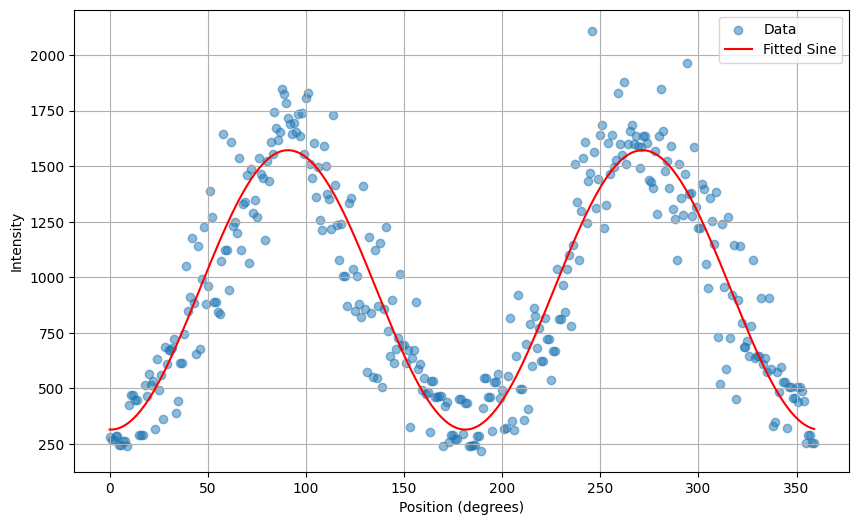

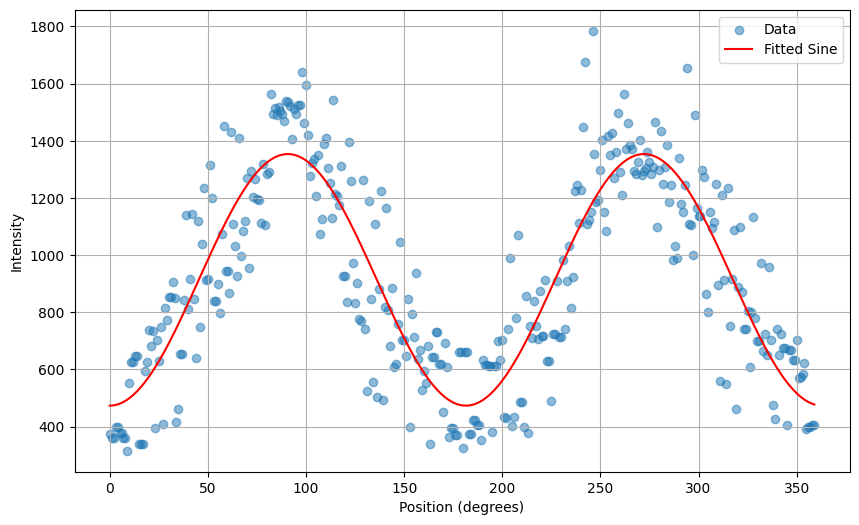

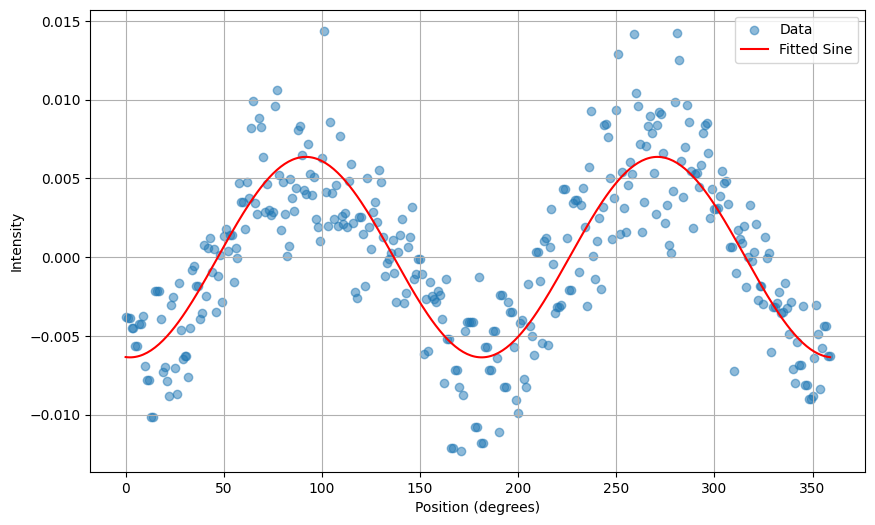

In [5]:
#main
GPMV_nb = input("Enter the GPMV number: ")

#deal with no points in the image
#use sum layer thresholding for all the channels ?

#fix GP calc
if not GPMV_nb:
    print("No GPMV number entered")
    raise ValueError

try:
    root, filename, data, channel_names, channel_emission = file_import()
except Exception as e:
    print("File import cancelled")
    raise e

#calc GP before, apply threshold after

if len(data.shape) == 4:
    slice_nb = slice_choice(data)
    slice_nb = int(slice_nb)  # Convert input to an integer
    data = data[:, slice_nb, :, :]

#add the gpmv number at the end of the filename
filename = filename + f"_GPMV{GPMV_nb}"

if len(channel_names) == 2:
    results_folder = os.path.join(root, "Results")
else:
    results_folder = os.path.join(root, "Spectral_Results")

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

sum_threshold = sum_threshold_selector(data)


if len(channel_names) == 2:
    if channel_emission[0] > channel_emission[1]:
        channel_names[0] = "red"
        channel_names[1] = "blue"
        GP_channel, sum_mask = GP_calc(data[1], data[0], sum_threshold)
    
    elif channel_emission[0] < channel_emission[1]:
        channel_names[0] = "blue"
        channel_names[1] = "red"
        GP_channel, sum_mask = GP_calc(data[0], data[1], sum_threshold)

    data = np.concatenate((data, GP_channel[np.newaxis, :, :]), axis=0)
    channel_names.append("GP")
    channel_emission.append("GP")

else:
    #sum all of the layers
    sum_mask = np.sum(data, axis=0).astype(np.float32) > sum_threshold



try:
    pixel, radius = select_pixel_radius(data)
    if pixel is None or radius is None:
        raise Exception
    else:
        print(radius)
        print(pixel)
except Exception as e:
    print("Object Selection cancelled")
    raise e

#
#create a polar_data array like data but with the polar transformed image channels. it will be of size (channels, radius, 360)
masked_polar_data = np.zeros((data.shape[0], 360, radius), dtype = np.float32)

for i in range(data.shape[0]):
    masked_layer = data[i].copy()
    masked_layer[~sum_mask] = 0
    masked_polar_data[i] = transform.warp_polar(masked_layer, center=pixel, radius=radius, order = 0)

napari.view_image(masked_polar_data, name="Masked Image", blending='translucent', opacity=0.5, colormap='grey')


analysis_results = dict()
# Calculate mean intensity profile
y_data = np.mean(masked_polar_data, axis=2)
#get the index of non zero values in y_data


x = np.arange(y_data.shape[1])
y_filtered = []
x = []
for i in range(y_data.shape[0]):
    row_i_nonzero = np.nonzero(y_data[i])[0]
    x.append(row_i_nonzero)
    y_filtered.append(y_data[i][row_i_nonzero])

#make an array of the same size as y_data where the second axis will contain the residuals of the median fit
median_res = []
for i in range(len(y_filtered)):
    popt, sin_fit, sin_r_squared, std = fit_sine_wave(x[i], y_filtered[i])
    median, median_r_squared, median_res_i = median_fit(x[i], y_filtered[i])
    median_res.append(median_res_i)
    analysis_results[i] = {'Radius': radius,
                            'Sum threshold': sum_threshold,
                            'Channel': channel_names[i],
                            'Emission': channel_emission[i],
                            'sin_fit': sin_fit,
                            'Amplitude': popt[0], 
                            'Frequency': popt[1], 
                            'Phase': popt[2],
                            'Offset': popt[3], 
                            'Sin_R_squared': sin_r_squared, 
                            'Standard_Deviation': std,
                            'Median': median,
                            'Median_R_squared': median_r_squared 
                            }
    #to add to analysis_results: R_squared Sin vs R_squared_median, Median, 
save_results(results_folder, filename, x, y_filtered, median_res, analysis_results)
#plot_median as well

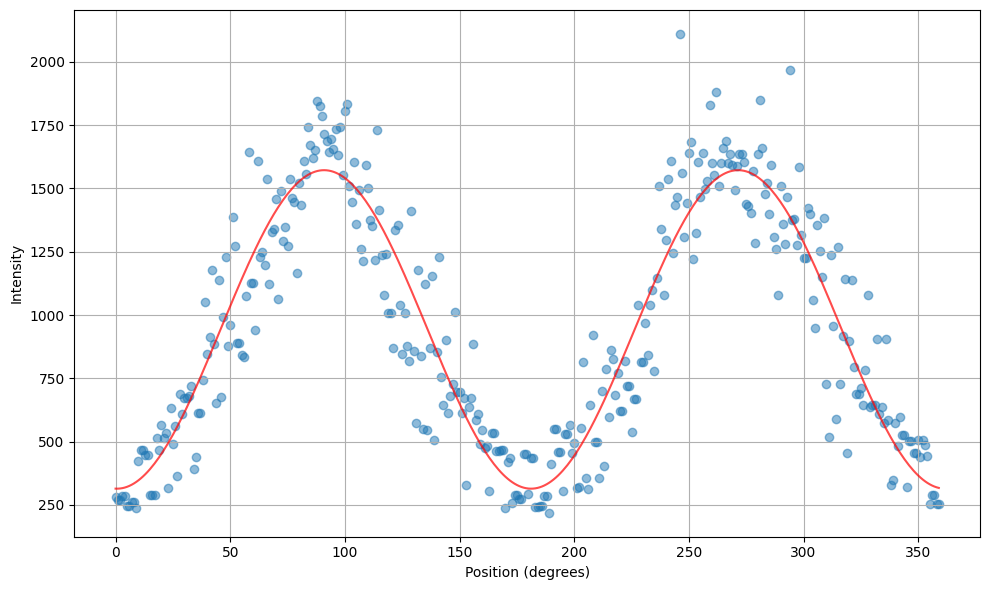

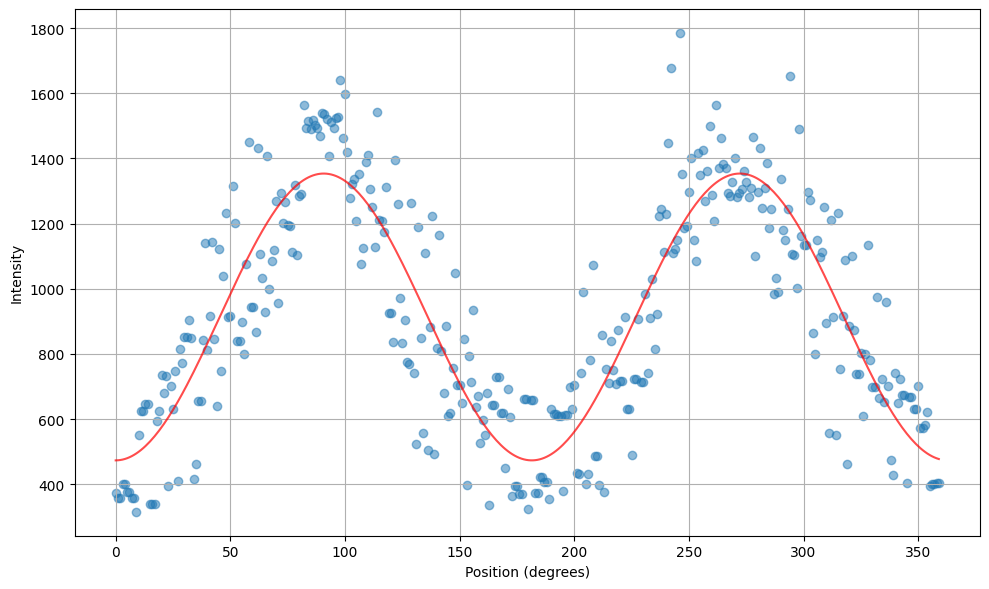

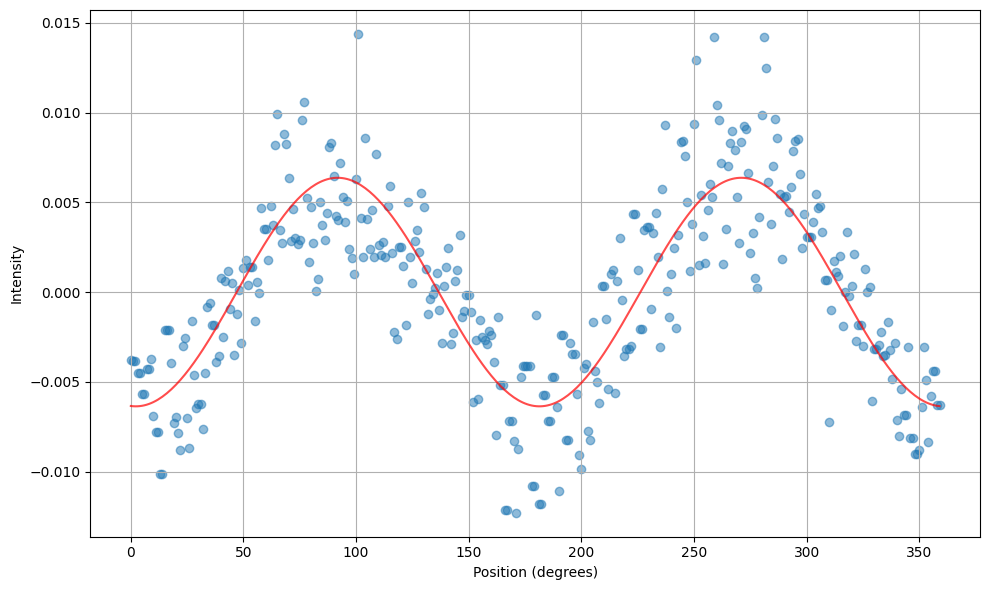

: 

In [ ]:
save_results(results_folder, filename, x, y_filtered, median_res, analysis_results)

In [15]:
print(channel_emission)
print(channel_names)

[689.5, 590.0, 'GP']
['red', 'blue', 'GP']


In [ ]:
print(channel_names)

['LLS1', 'LLS2', 'GP']


In [37]:
#result plotting for channel profile analysis
import seaborn as sns
from scipy.stats import mstats

def import_results():
    folder_dict = dict()

    NR4A_path = filedialog.askdirectory(title="Select the NR4A folder")
    if NR4A_path:
        folder_dict["NR4A"] = NR4A_path
        print("NR4A folder selected.")

    NR12A_path = filedialog.askdirectory(title="Select the NR12A folder")
    if NR12A_path:
        folder_dict["NR12A"] = NR12A_path
        print("NR12A folder selected.")

    NR12S_path = filedialog.askdirectory(title="Select the NR12S folder")
    if NR12S_path:
        folder_dict["NR12S"] = NR12S_path
        print("NR12S folder selected.")

    Pro12A_path = filedialog.askdirectory(title="Select the Pro12A folder")
    if Pro12A_path:
        folder_dict["Pro12A"] = Pro12A_path
        print("Pro12A folder selected.")

    if not NR4A_path and not NR12A_path and not NR12S_path and not Pro12A_path:
        print("Invalid folder selection.")
        raise ValueError("No folders selected.")
    
    figures_path = filedialog.askdirectory(title="Select the folder to save figures")
    if not figures_path:
        print("No figures folder selected.")
        raise ValueError("No figures folder selected.")
    
    return folder_dict, figures_path

def extract_results(folder_dict):
    #results in dictionary with 2 big dataframes per folder with columns amplitude, frequency, phase, offset, sin_r_squared, std, median, median_r_squared
    #get the different channel entries in the first csv file of the first folder
    results_dict = dict()  # Dictionary to store data for each condition

    # Loop through each folder (NR4A, NR12A, etc.)
    for condition, folder_path in folder_dict.items():
        csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
        results_dict[condition] = dict()
        if not csv_files:
            print(f"No CSV files found in {folder_path}")
            continue

        df_list = []  # List to store DataFrames

        for file in csv_files:
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            df["Condition"] = condition  # Add condition column
            df_list.append(df)

        # Concatenate all DataFrames for the current condition
        combined_df = pd.concat(df_list, ignore_index=True)
        #make all amplitudes positive
        combined_df["Amplitude"] = np.abs(combined_df["Amplitude"])
        channel_list = combined_df["Channel"].unique().tolist()
        for ch in channel_list:
            results_dict[condition][ch] = combined_df[combined_df["Channel"] == ch]

    '''deprecated
    # Ensure all DataFrames have the same columns
    reference_df = None

    for condition, channels in results_dict.items():
        for ch, df in channels.items():
            if reference_df is None:
                reference_df = df  # Pick the first available DataFrame as reference
                reference_columns = set(reference_df.columns)
            else:
                if set(df.columns) != reference_columns:
                    raise ValueError(
                        f"Dataframe for Channel '{ch}' in Condition '{condition}' "
                        f"does not match reference columns:\nExpected: {sorted(reference_columns)}\n"
                        f"Found: {sorted(df.columns)}"
                    )
    '''
    #get the list of channels from results_dict
    all_channels = set()    
    for condition, channel_dict in results_dict.items():
        condition_channels = set(channel_dict.keys())
        all_channels.update(condition_channels)
    
    return results_dict, sorted(list(all_channels))

def winsorize_outliers(df, col):
    # Apply winsorization (cap values at 1st and 99th percentiles)
    return df.assign(**{col: mstats.winsorize(df[col], limits=[0.2, 0.2])})

def plot_results(results_dict, columns, channels, figures_path):
    # Special columns where GP channel should have independent limits
    gp_independent_columns = ['Amplitude', "Standard_Deviation", "Median", 'Offset']
    
    ordered_channels = [ch for ch in channels if ch != 'GP']
    if 'GP' in channels:
        ordered_channels.append('GP')
    
    result_types = list(results_dict.keys())  # Extract all result types dynamically
    muted_palette = sns.color_palette("muted", len(result_types))
    palette_dict = dict(zip(result_types, muted_palette))  # Map result types to colors

    for col in columns:
        fig, axes = plt.subplots(1, len(channels), figsize=(9, 9))  # Removed sharey=True
        fig.suptitle(f'{col}')
        
        for i, channel in enumerate(ordered_channels):
            print(f"Plotting {col} for {channel}")
            plot_data = []
            for result_type, dictionary in results_dict.items():
                if col in dictionary[channel].columns:
                    df = dictionary[channel][[col]].copy()
                    df["Result Type"] = result_type
                    
                    # Winsorize outliers in the dataframe
                    df = winsorize_outliers(df, col)
                    
                    plot_data.append(df)

            if plot_data:  # Check if we have data to plot
                df_plot = pd.concat(plot_data)

                # Create violin plot
                sns.violinplot(x="Result Type", y=col, hue="Result Type", data=df_plot, ax=axes[i], 
                palette='muted', legend=False)
                axes[i].set_title(channel)
                
                
                if 'Emission' in df_plot.columns:
                    axes[i].set_xticklabels(df_plot['Emission'].unique(), rotation=45)

                # If this is not the GP channel or not a special column, share y axis with first plot
                if not (channel == 'GP' and col in gp_independent_columns):
                    if i > 0:  # For all plots except the first one
                        axes[i].set_ylim(axes[0].get_ylim())

            #if there is a channel_emission column, use it as x axis label
            if 'Emission' in df_plot.columns:
                    axes[i].set_xticklabels(df_plot['Emission'].unique(), rotation=45)
            else:
                axes[i].set_xticklabels([])  # **Remove x-axis condition labels**
                
            axes[i].set_xlabel('')
            axes[i].set_ylabel('')
            

        # Create a single legend for the figure
        legend_patches = [mpatches.Patch(color=color, label=label) for label, color in palette_dict.items()]
        fig.legend(handles=legend_patches, title="Dye used", loc='upper right', bbox_to_anchor=(1.05, 1.06))
        
        plt.tight_layout()
        plt.show()
        # Save figure
        fig_path = os.path.join(figures_path, f"ViolinPlot_{col}.png")
        fig.savefig(fig_path)

def plot_spectral_results(results_dict, columns, channels, figures_path):
    """
    Plot spectral results with one subplot per result_type, showing all channels within each subplot.
    Missing channels are represented with zeros and a distinct visual style.
    
    Parameters:
    results_dict: Dict of dict, where first level key is result_type and second level key is channel
    columns: List of column names to plot
    channels: List of channel names to include
    """
    for col in columns:
        # Get number of result types for subplot layout
        num_result_types = len(results_dict)
        
        # Create figure and subplots
        fig, axes = plt.subplots(num_result_types, 1, figsize=(9, 2*num_result_types))
        fig.suptitle(f'{col}', fontsize=14, y=1.0)
        
        # Convert to array of axes if there's only one result type
        if num_result_types == 1:
            axes = [axes]

        result_types = list(results_dict.keys())
        color_palette = sns.color_palette("muted", len(result_types))
        palette_dict = dict(zip(result_types, color_palette))  # Map each result type to a unique color
        
        # Plot each result type in its own subplot
        for i, (result_type, dictionary) in enumerate(results_dict.items()):
            plot_data = []
            missing_channels = []
            
            # Collect data for all channels for this result type
            for channel in channels:
                if channel in dictionary and col in dictionary[channel].columns:
                    df = dictionary[channel][[col]].copy()
                    df['Channel'] = channel
                    df['Missing'] = False
                    df['Result Type'] = result_type
                    
                    # Winsorize outliers in the dataframe
                    df = winsorize_outliers(df, col)
                    
                    plot_data.append(df)
                else:
                    # Create dummy dataframe with zeros for missing channels
                    missing_channels.append(channel)
                    df = pd.DataFrame({
                        col: [0] * 10,  # Create multiple zero points for better violin plot
                        'Channel': [channel] * 10,
                        'Missing': [True] * 10
                    })
                    plot_data.append(df)
            
            # Combine all channel data for this result type
            df_plot = pd.concat(plot_data)
            
            # Create violin plot in the appropriate subplot
            sns.violinplot(x="Channel", y=col, hue="Result Type", data=df_plot[~df_plot['Missing']], 
                           ax=axes[i], palette=palette_dict, legend=False)
            
            # Customize subplot
            axes[i].tick_params(axis='both', labelsize=9)
            axes[i].set_ylabel('')
            axes[i].set_xlabel('')
            
            # Rotate x-axis labels if they're too long
            if max([len(str(ch)) for ch in channels]) > 8:
                axes[i].tick_params(axis='x', rotation=45)
        
         # Create a single legend for the figure
        legend_patches = [mpatches.Patch(color=color, label=label) for label, color in palette_dict.items()]
        fig.legend(handles=legend_patches, title="Result Type", loc='upper right', bbox_to_anchor=(1.05, 1.06))
        
        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()
        fig_path = os.path.join(figures_path, f"ViolinPlot_{col}.png")
        fig.savefig(fig_path)

def save_summary(results_dict, channels, figures_path):
    save_rows = ["Amplitude", "Sin_R_squared"]
    summary_df = pd.DataFrame(columns=["Condition", "Parameter"] + channels)
    
    for condition, channel_dict in results_dict.items():
        # Create a temporary dataframe to store medians
        condition_df = pd.DataFrame(index=save_rows, columns=channels)
        
        for ch, df in channel_dict.items():
            for row in save_rows:
                condition_df.at[row, ch] = df[row].median()
        
        # Add 'Parameter' column using the index
        condition_df.insert(0, "Parameter", [row.replace("_", " ") for row in condition_df.index])
        # Add 'Condition' column
        condition_df.insert(0, "Condition", condition)
        
        # Append to summary
        summary_df = pd.concat([summary_df, condition_df], axis=0)

    # Save to CSV
    summary_path = os.path.join(figures_path, "Summary.csv")
    summary_df.to_csv(summary_path, index=False)




NR4A folder selected.
NR12A folder selected.
NR12S folder selected.
Plotting Amplitude for LLS1
Plotting Amplitude for LLS2
Plotting Amplitude for GP


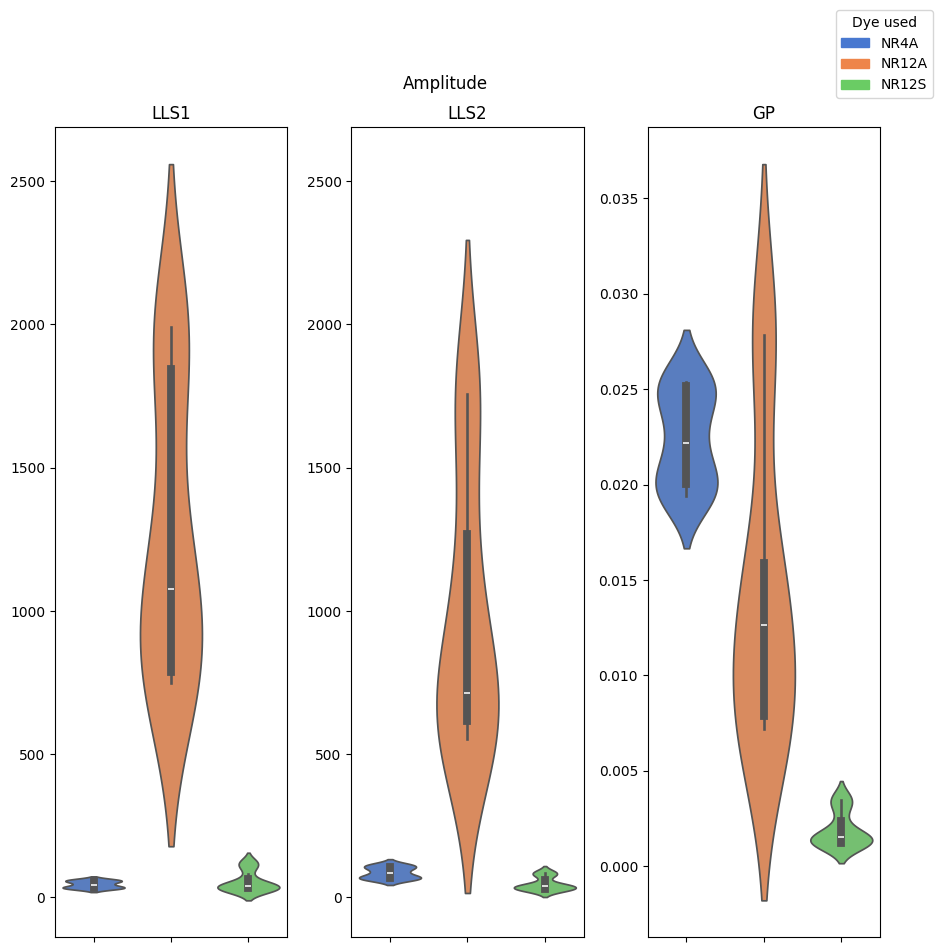

Plotting Frequency for LLS1
Plotting Frequency for LLS2
Plotting Frequency for GP


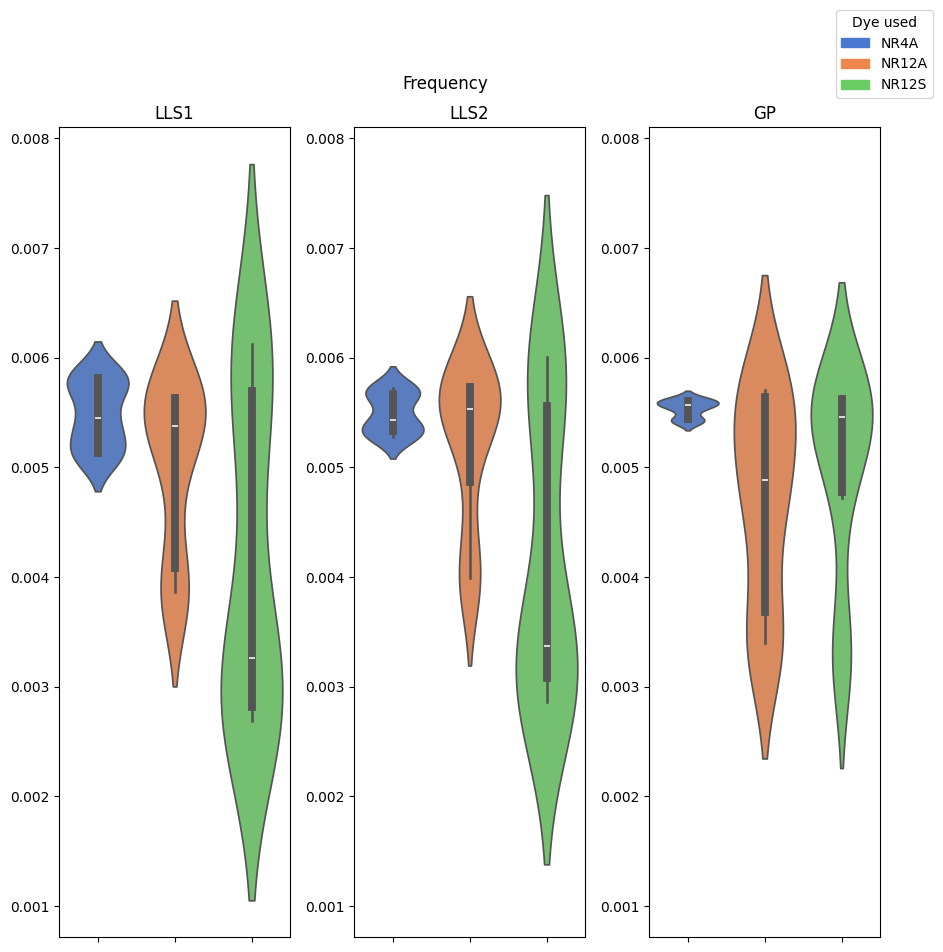

Plotting Phase for LLS1
Plotting Phase for LLS2
Plotting Phase for GP


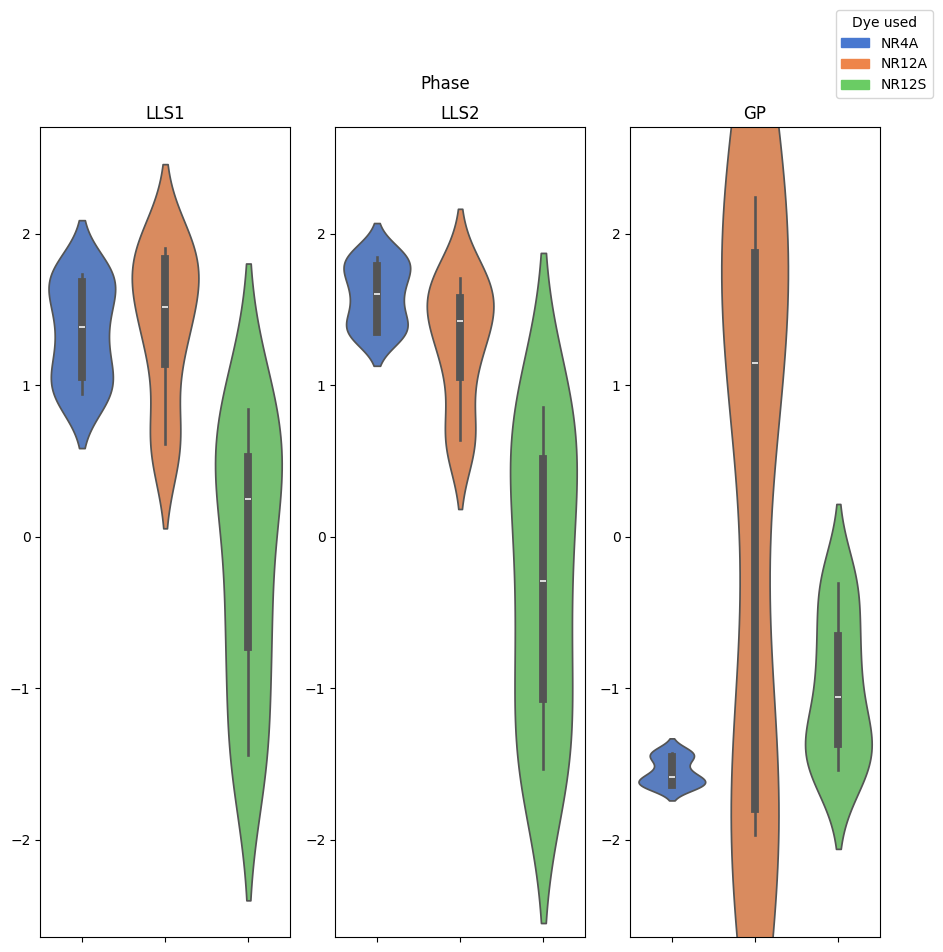

Plotting Offset for LLS1
Plotting Offset for LLS2
Plotting Offset for GP


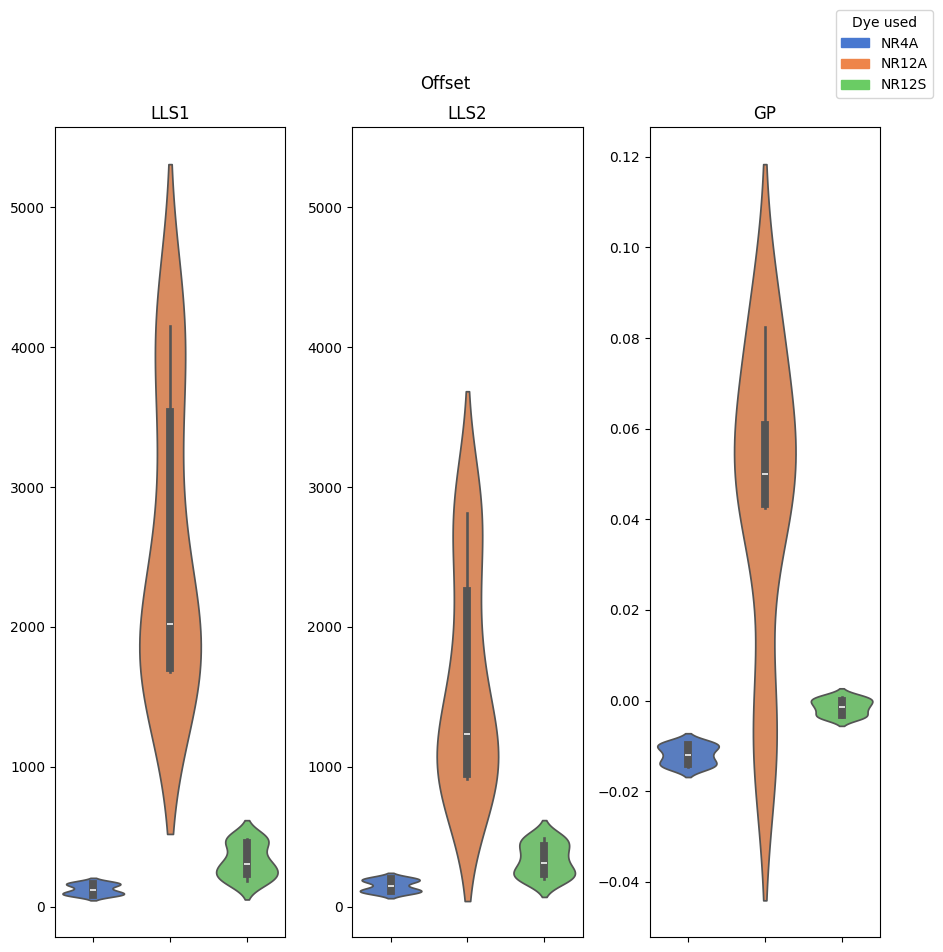

Plotting Sin_R_squared for LLS1
Plotting Sin_R_squared for LLS2
Plotting Sin_R_squared for GP


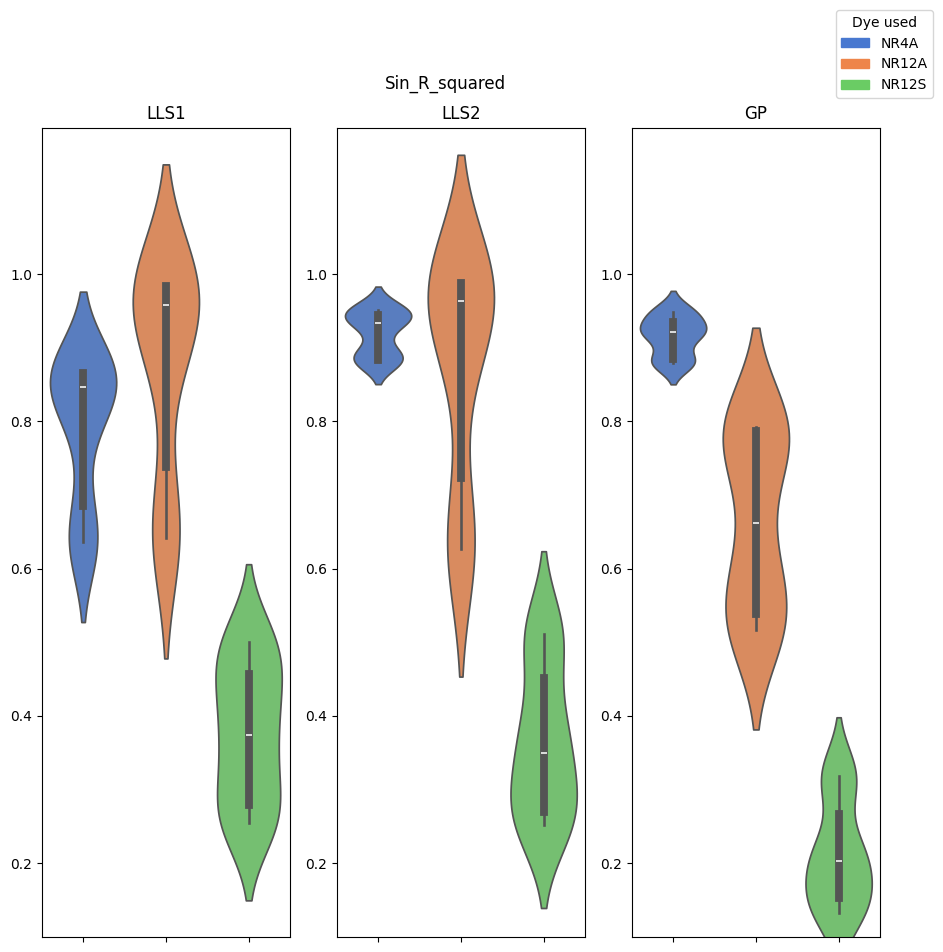

Plotting Standard_Deviation for LLS1
Plotting Standard_Deviation for LLS2
Plotting Standard_Deviation for GP


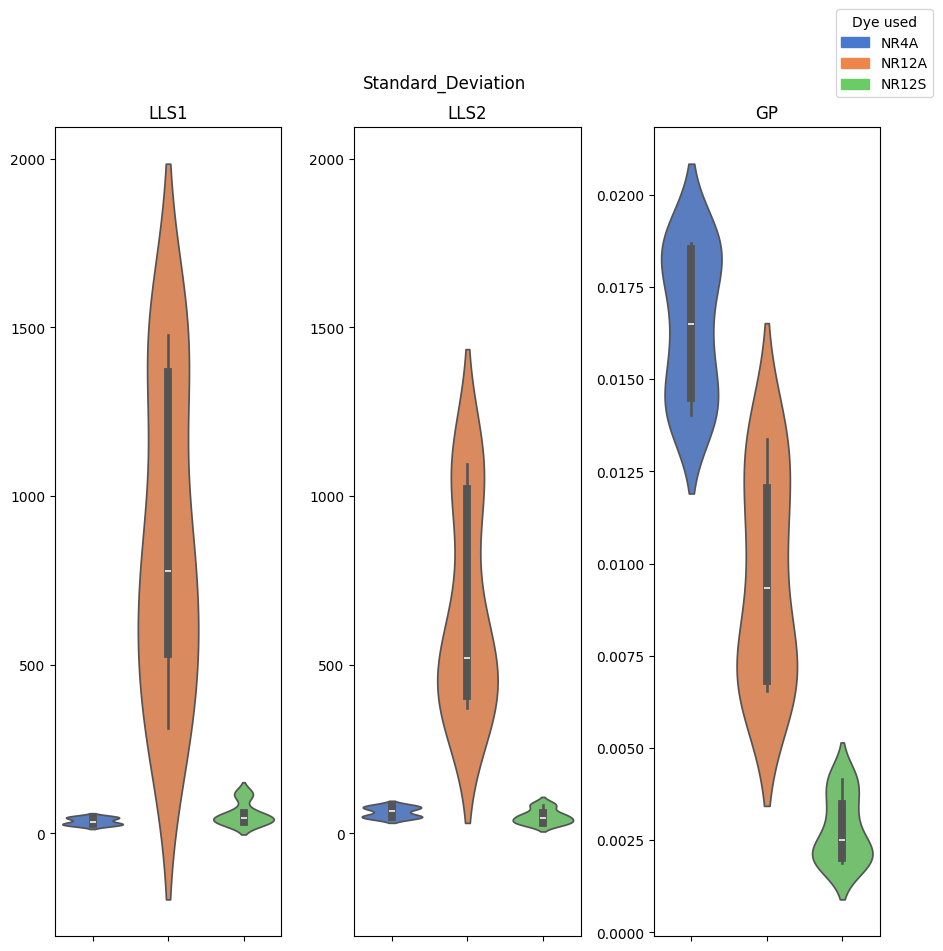

Plotting Median for LLS1
Plotting Median for LLS2
Plotting Median for GP


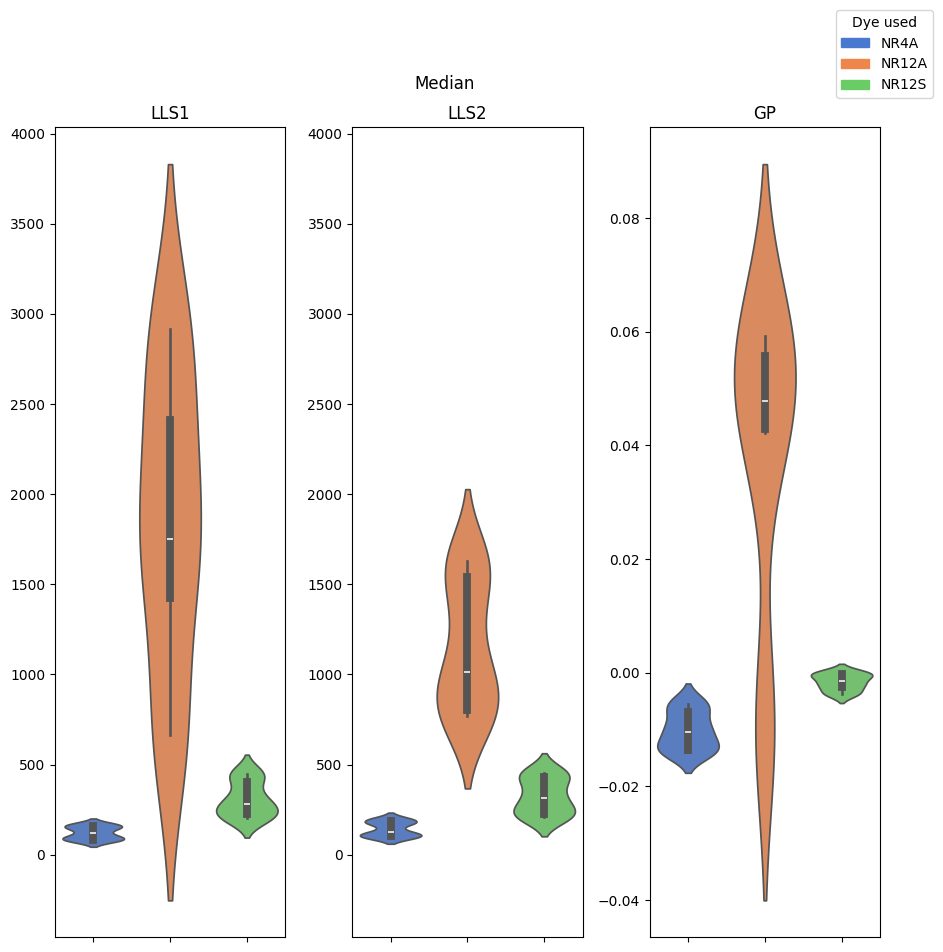

Plotting Median_R_squared for LLS1
Plotting Median_R_squared for LLS2
Plotting Median_R_squared for GP


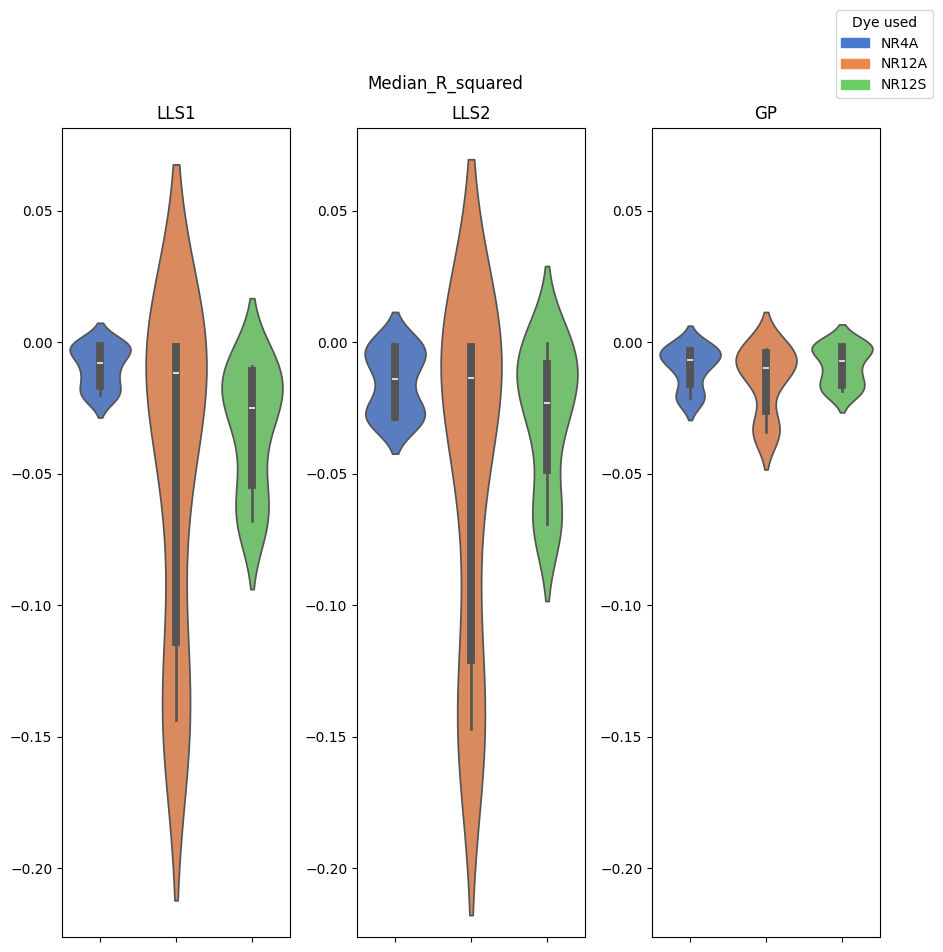

In [38]:
folder_dict, figures_path = import_results()

results_dict, channels = extract_results(folder_dict)

plot_columns = ["Amplitude", "Frequency", "Phase", "Offset", "Sin_R_squared", "Standard_Deviation", "Median", "Median_R_squared"]
plot_results(results_dict, plot_columns, channels,figures_path)

save_summary(results_dict, channels, figures_path)

#plot the results

Plotting Amplitude for LLS1
Plotting Amplitude for LLS2
Plotting Amplitude for GP


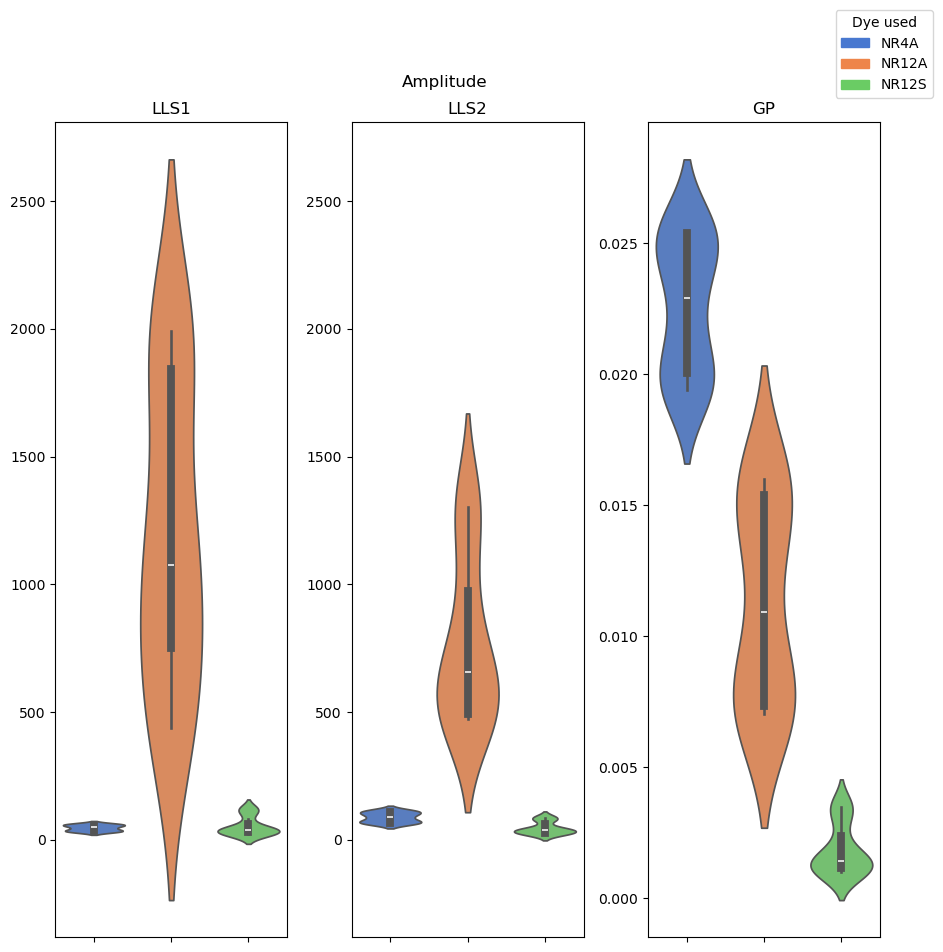

Plotting Frequency for LLS1
Plotting Frequency for LLS2
Plotting Frequency for GP


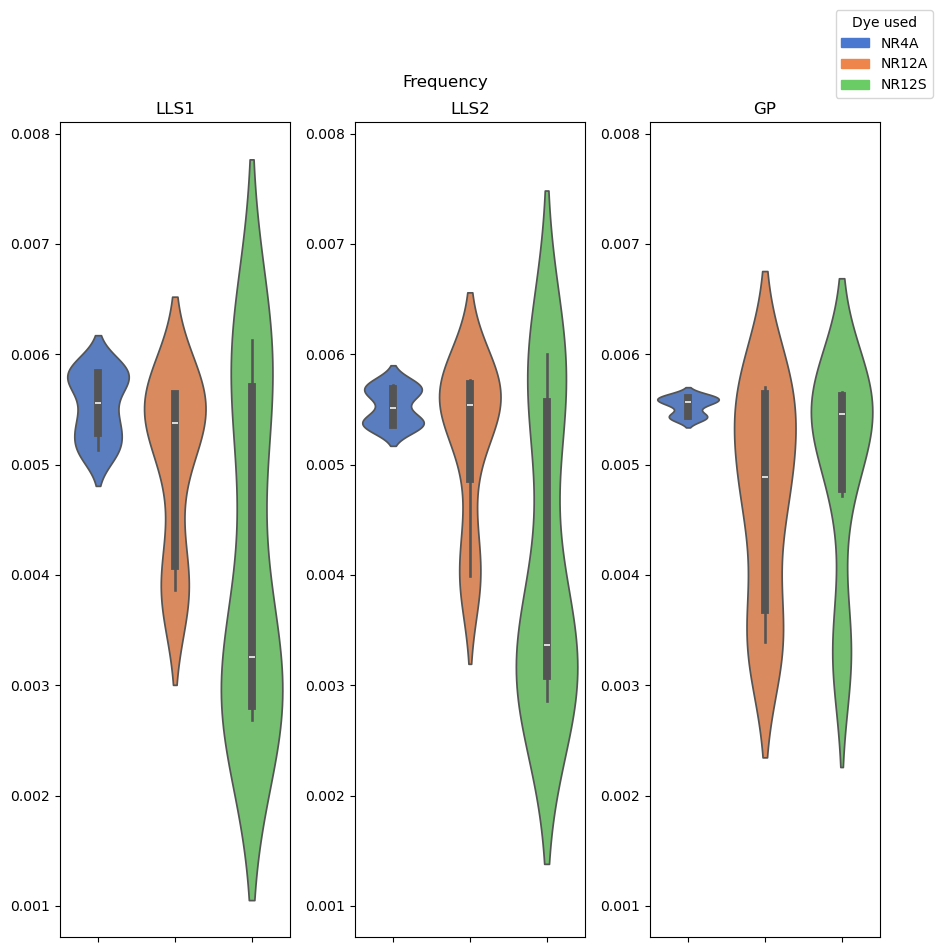

Plotting Phase for LLS1
Plotting Phase for LLS2
Plotting Phase for GP


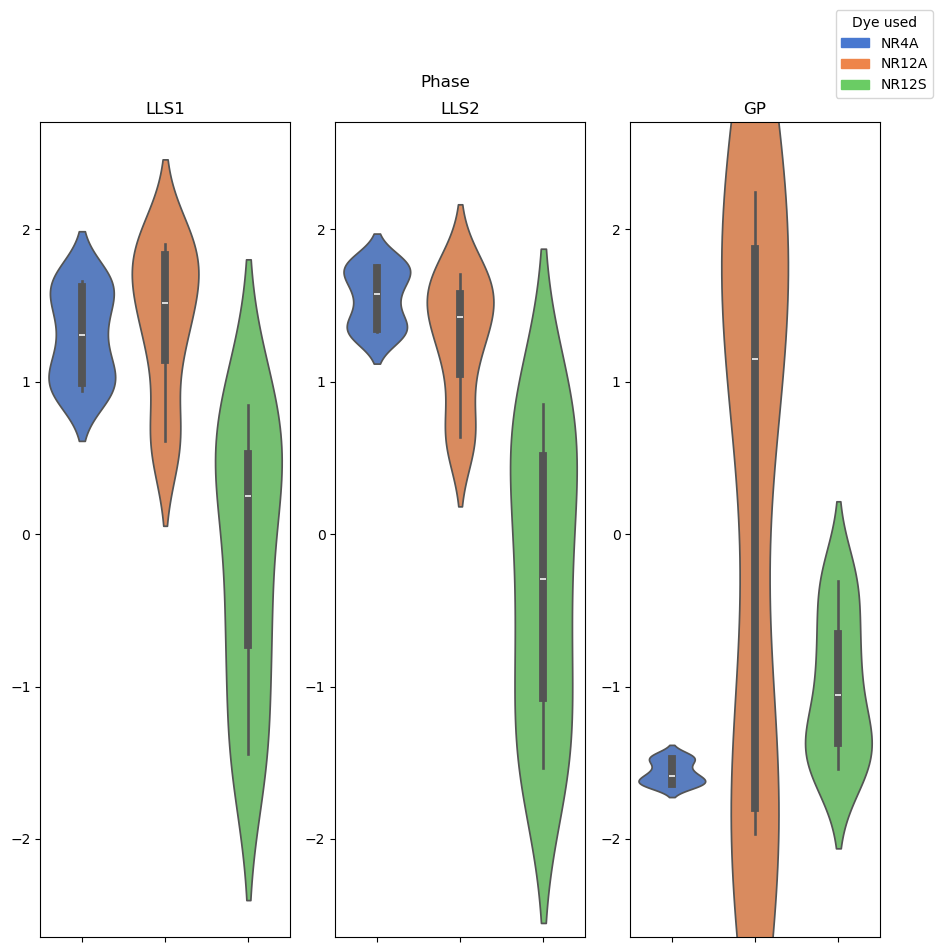

Plotting Offset for LLS1
Plotting Offset for LLS2
Plotting Offset for GP


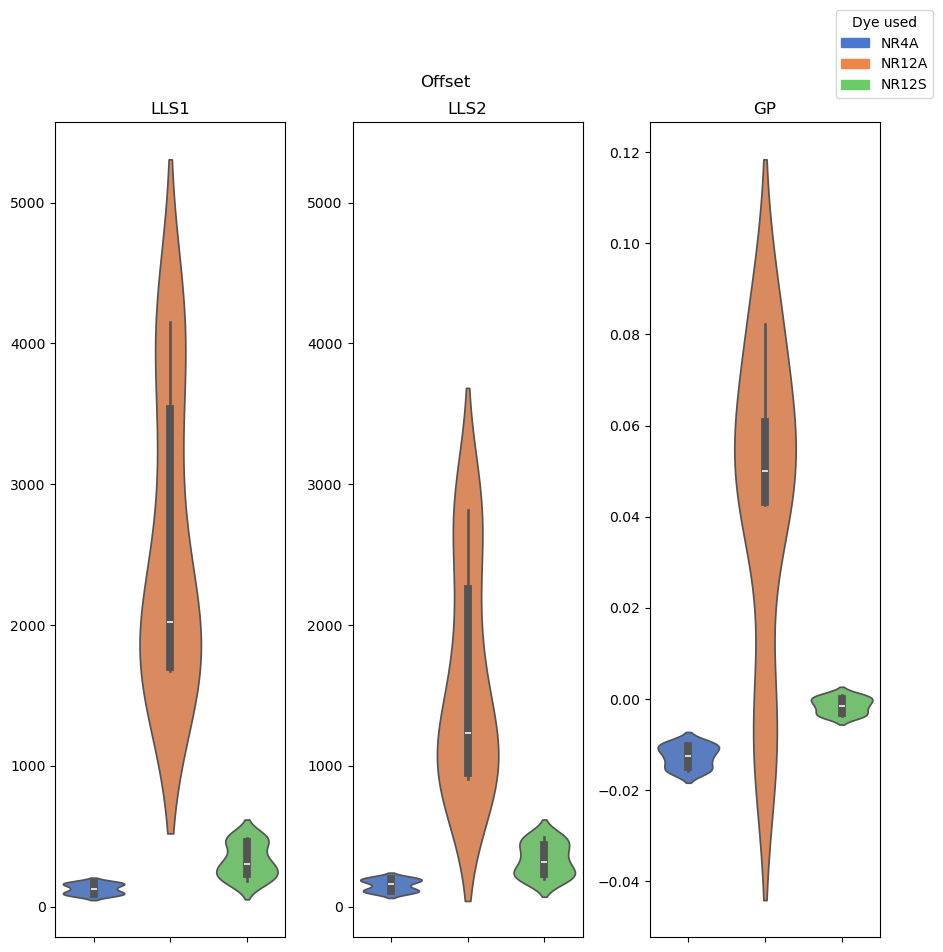

Plotting Sin_R_squared for LLS1
Plotting Sin_R_squared for LLS2
Plotting Sin_R_squared for GP


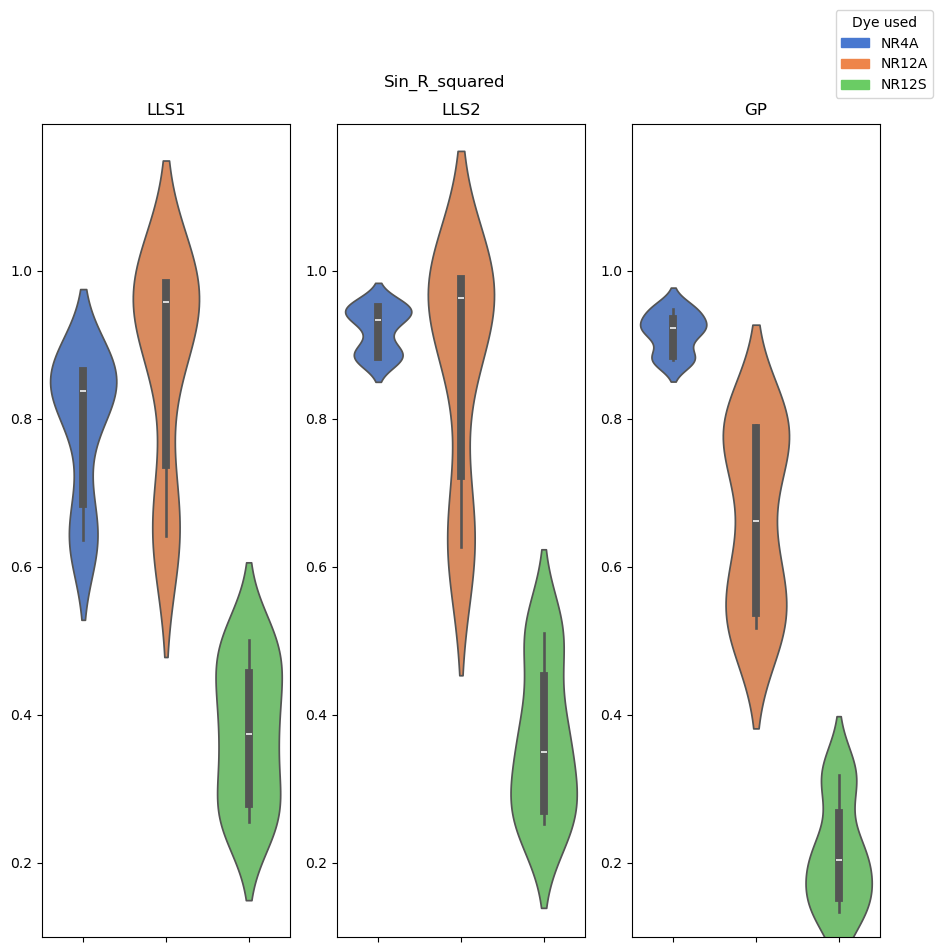

Plotting Standard_Deviation for LLS1
Plotting Standard_Deviation for LLS2
Plotting Standard_Deviation for GP


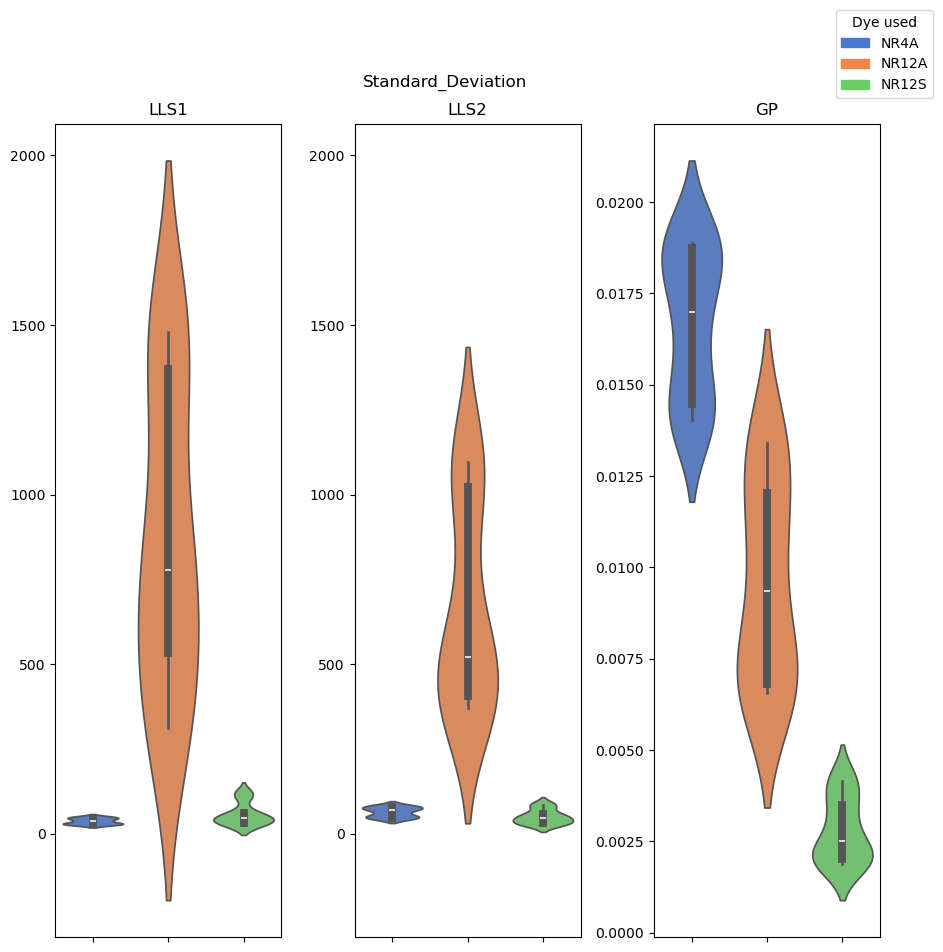

Plotting Median for LLS1
Plotting Median for LLS2
Plotting Median for GP


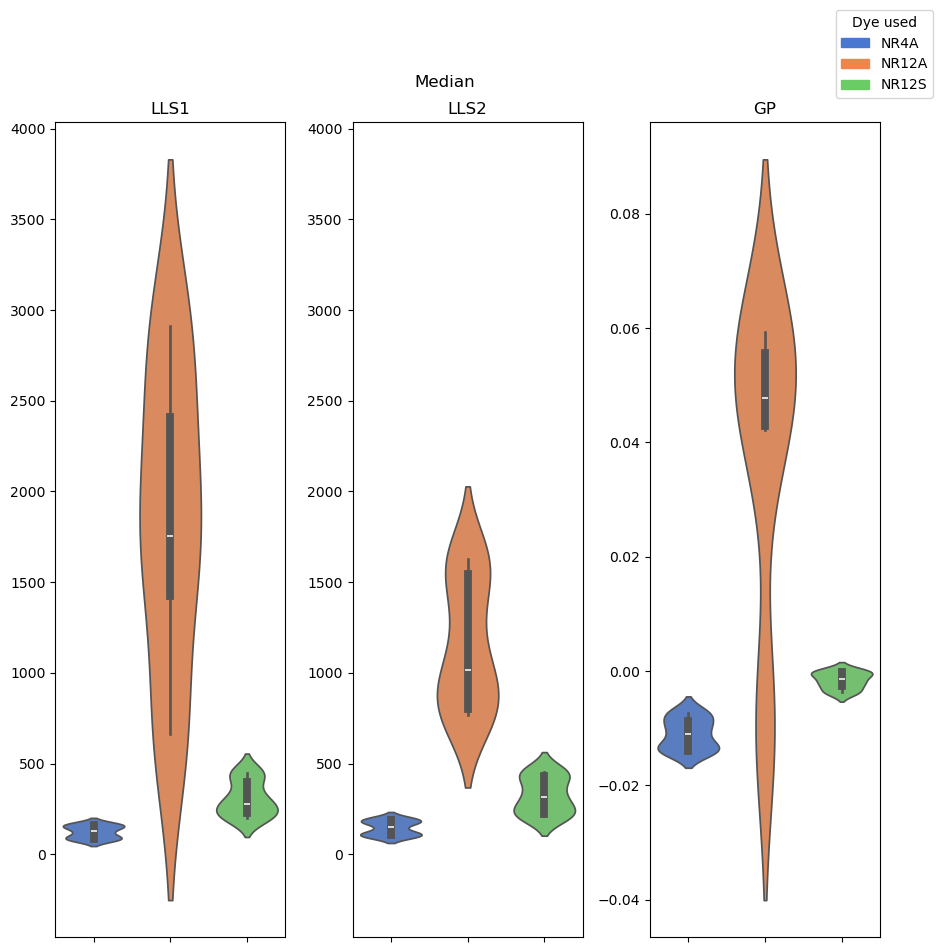

Plotting Median_R_squared for LLS1
Plotting Median_R_squared for LLS2
Plotting Median_R_squared for GP


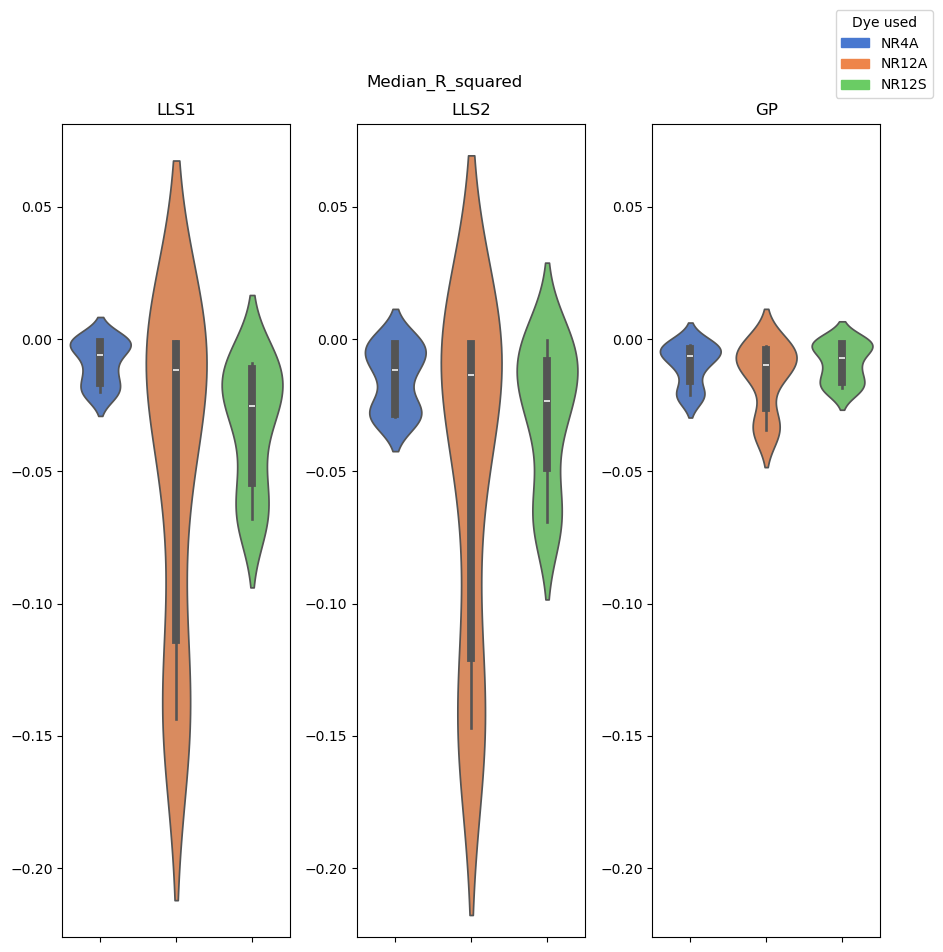

In [40]:
plot_results(results_dict, plot_columns, channels,figures_path)


NR4A folder selected.
NR12A folder selected.
NR12S folder selected.


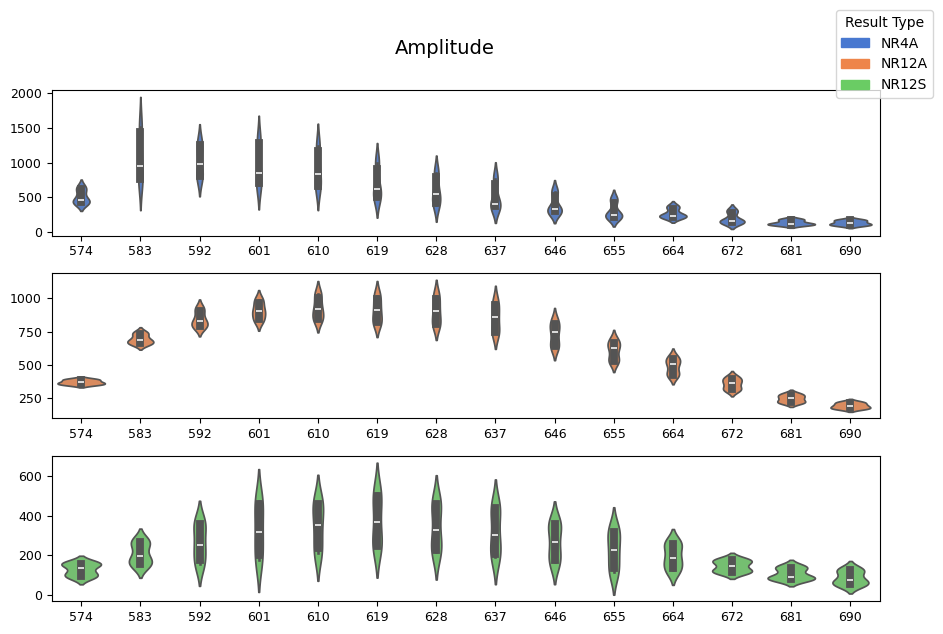

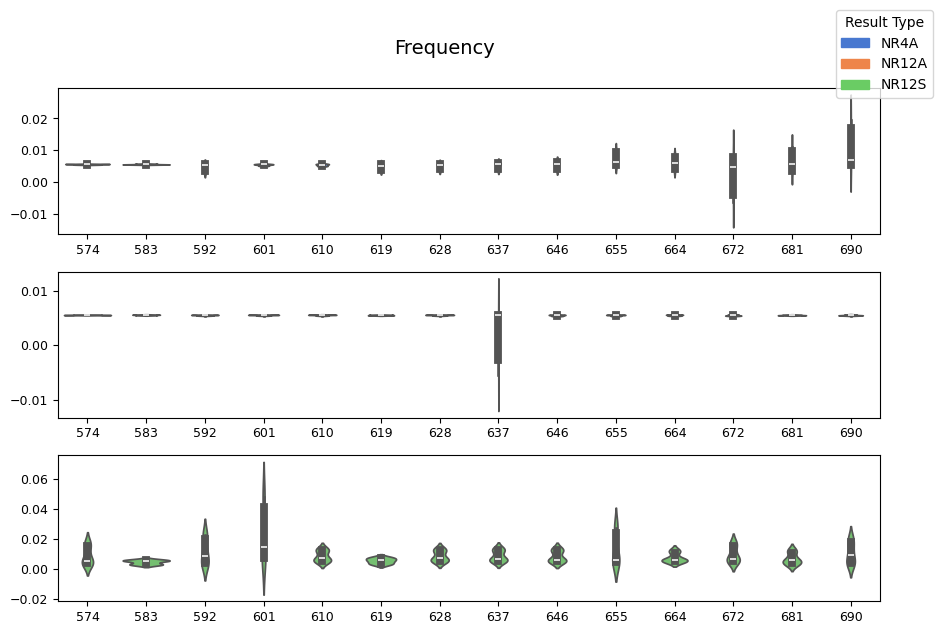

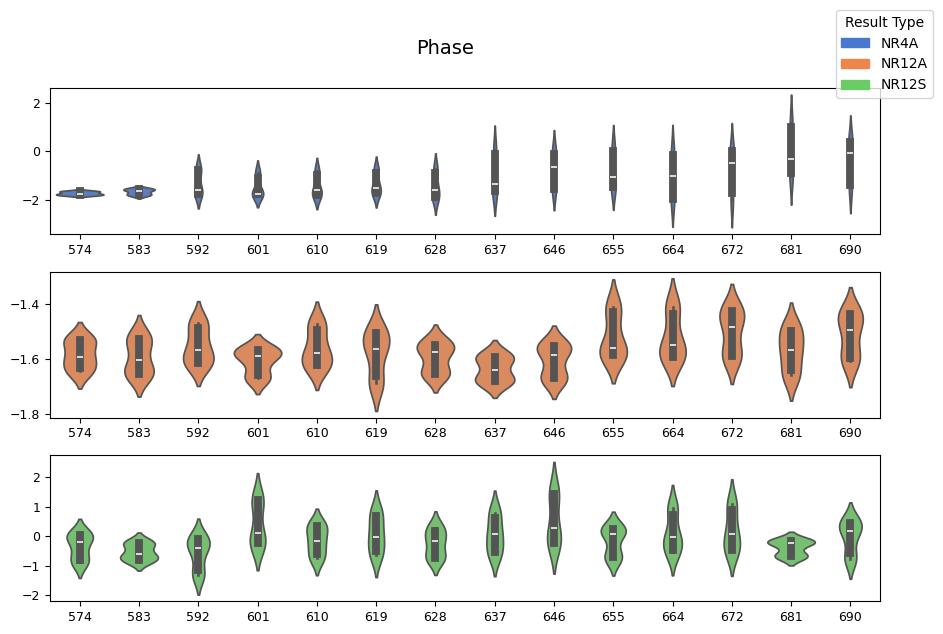

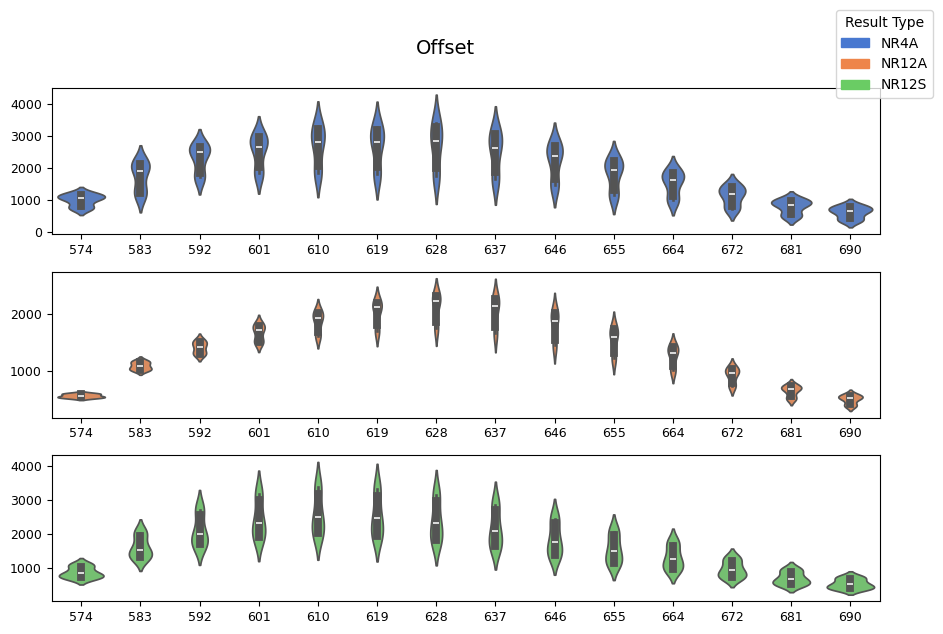

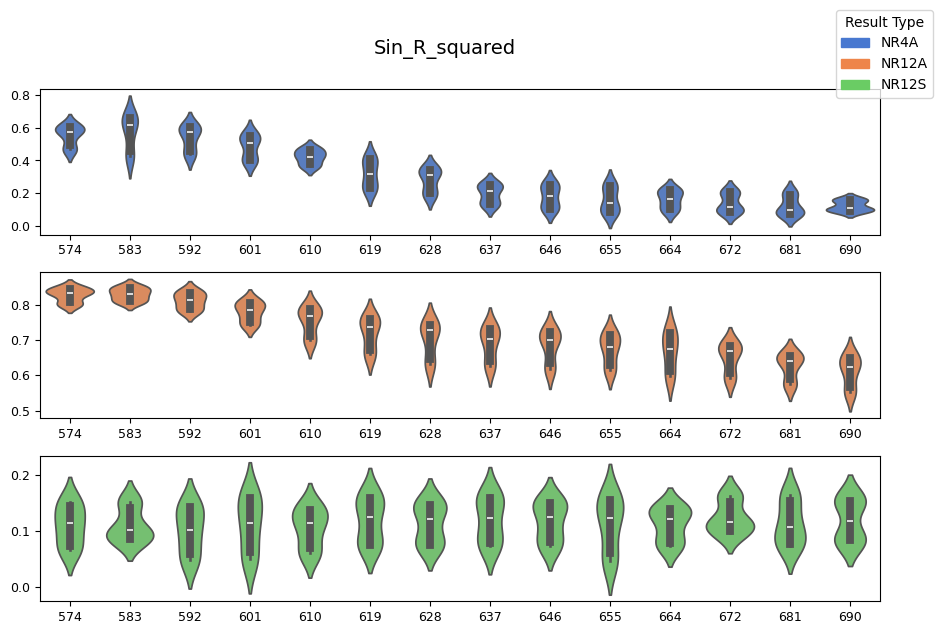

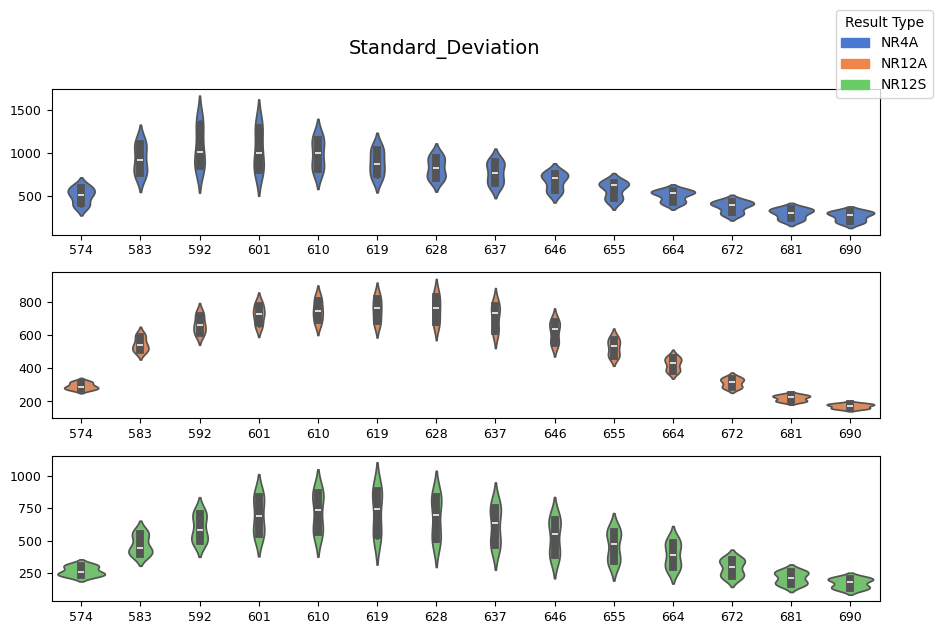

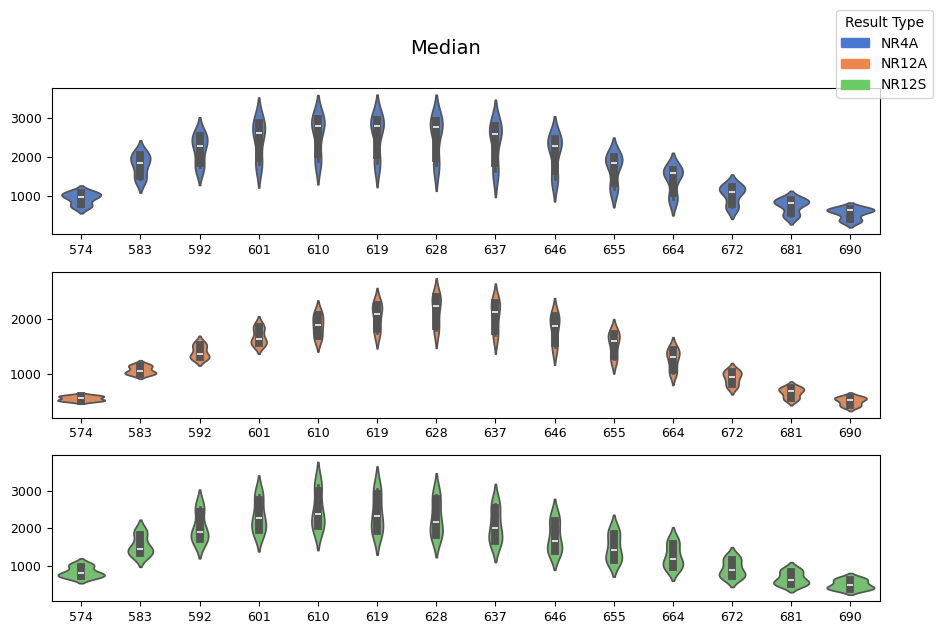

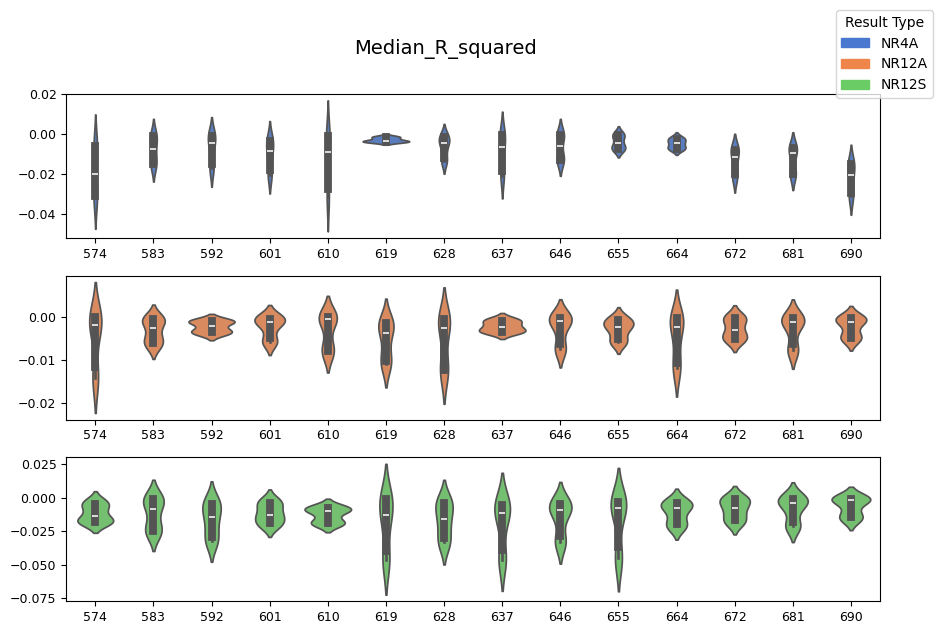

In [39]:
folder_dict, figures_path = import_results()

results_dict, channels = extract_results(folder_dict)

plot_columns = ["Amplitude", "Frequency", "Phase", "Offset", "Sin_R_squared", "Standard_Deviation", "Median", "Median_R_squared"]
plot_spectral_results(results_dict, plot_columns, channels, figures_path)

save_summary(results_dict, channels, figures_path)


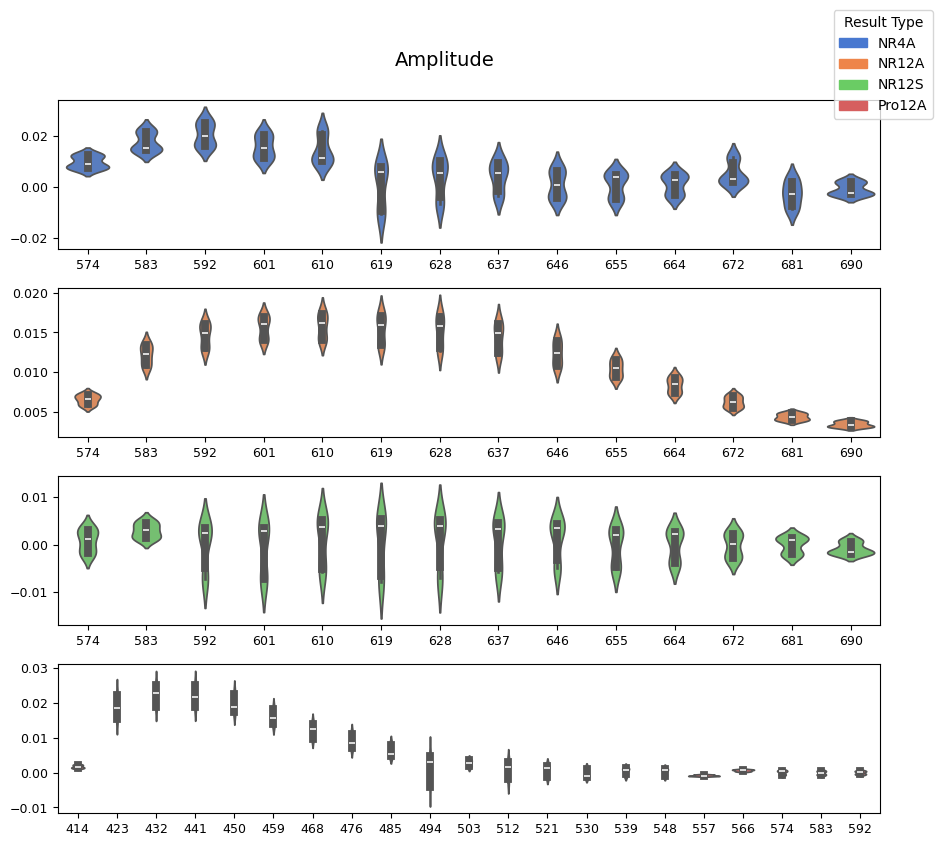

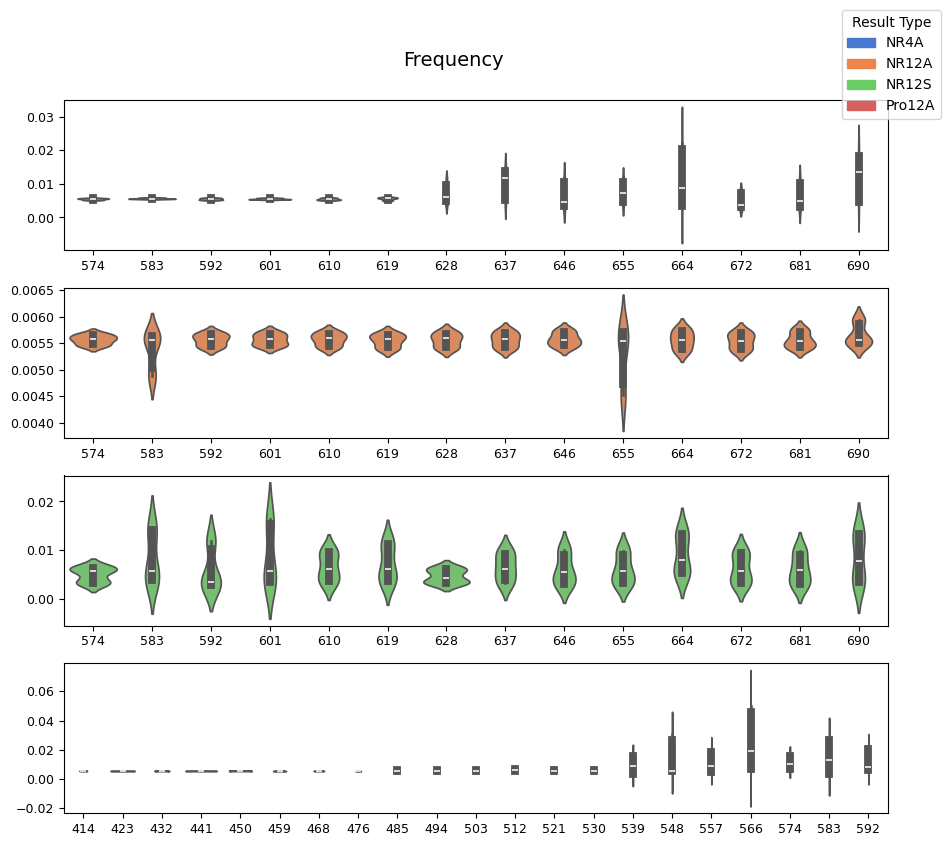

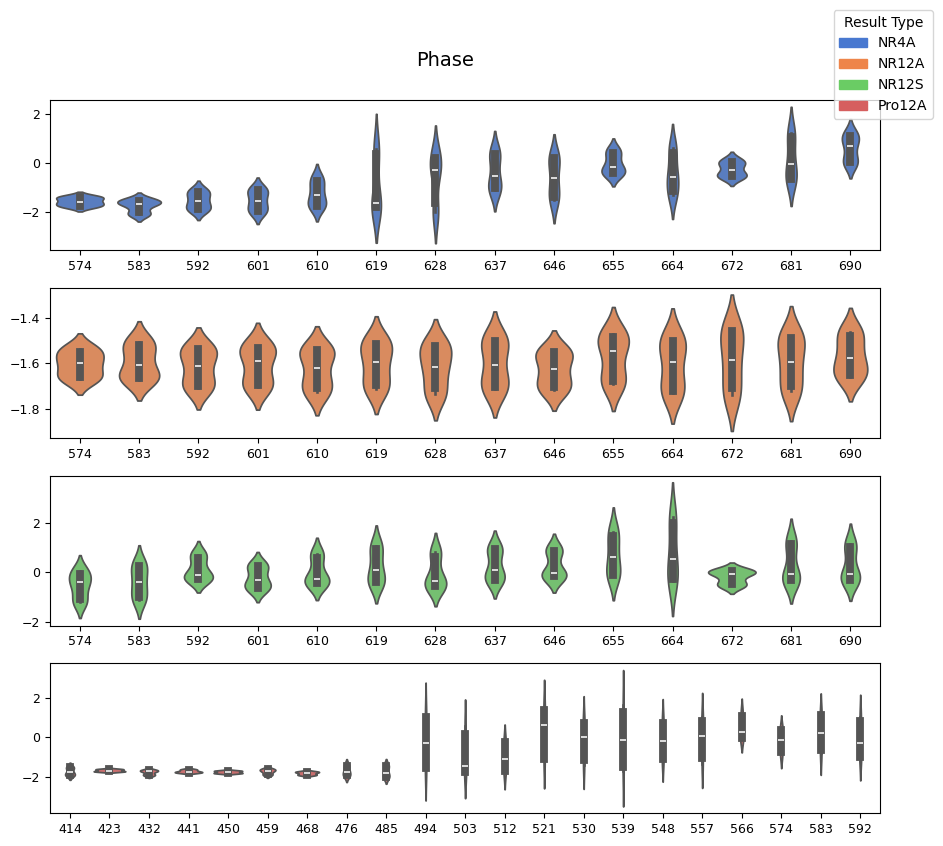

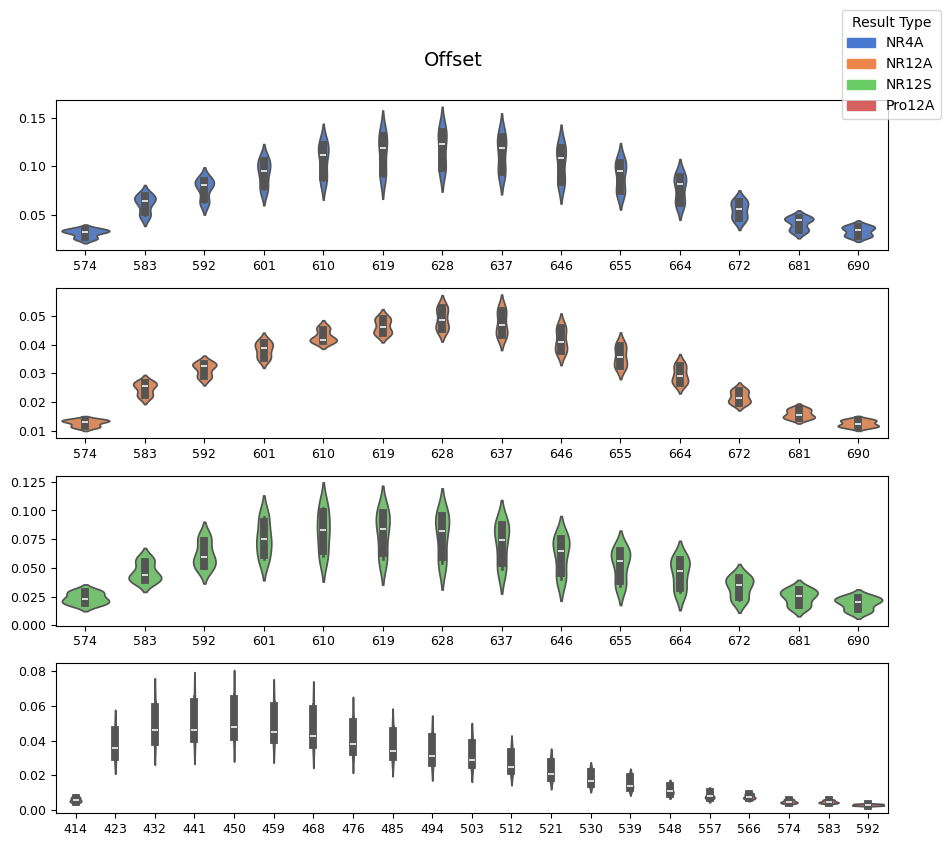

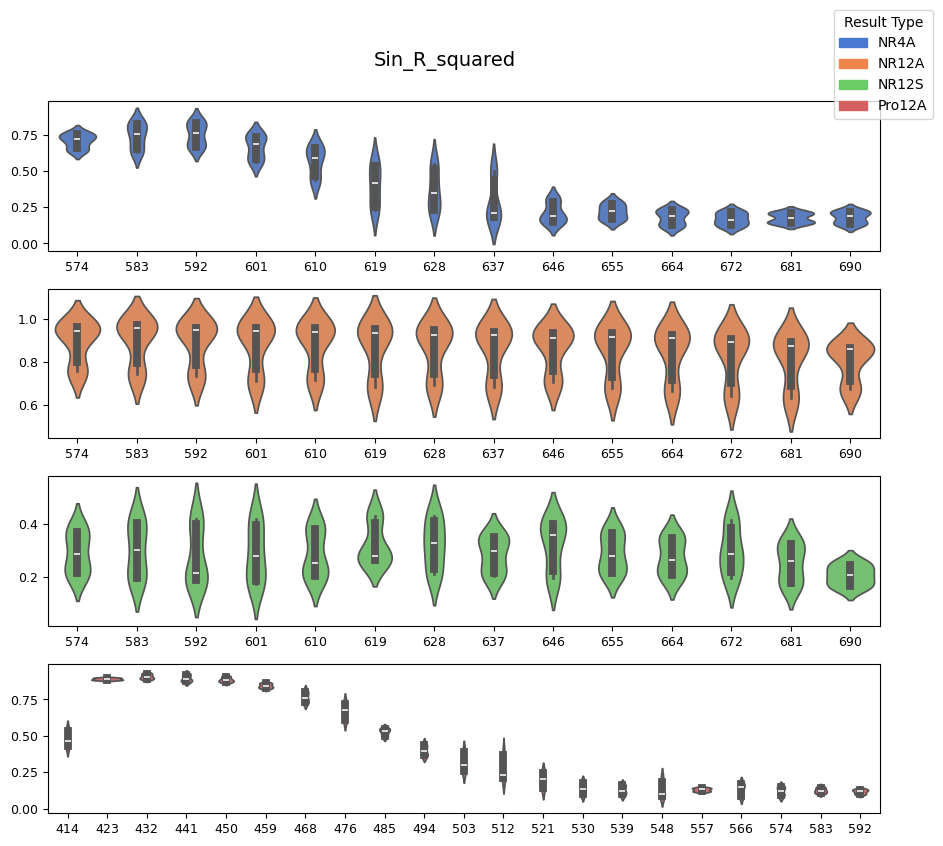

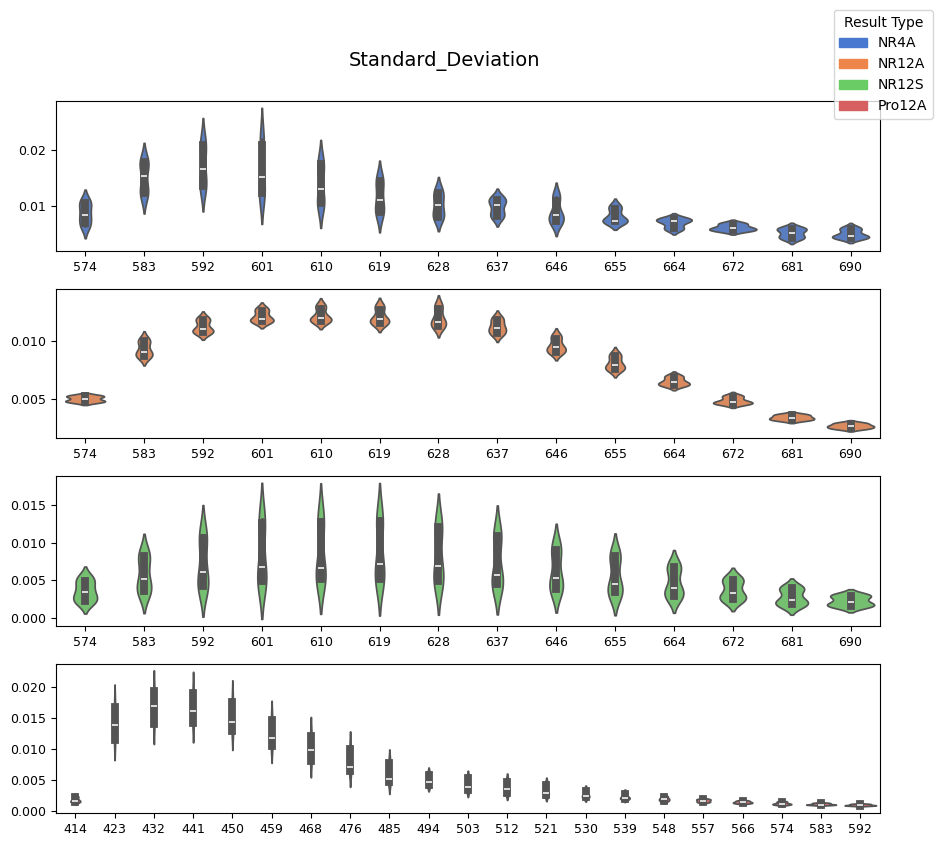

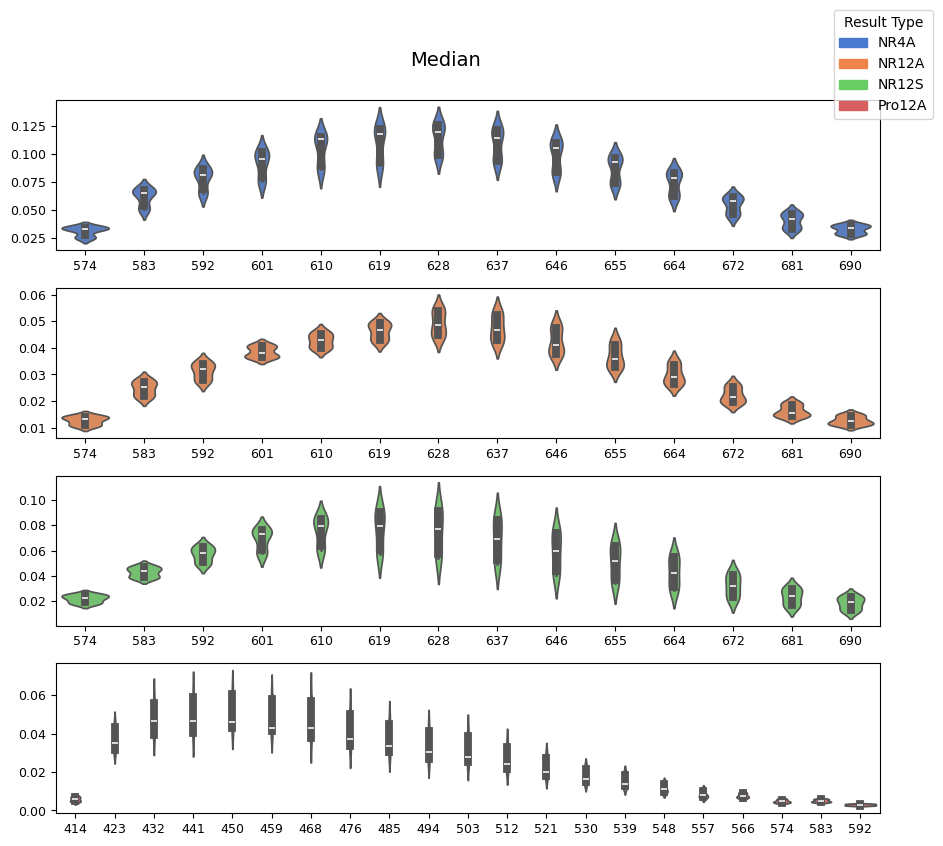

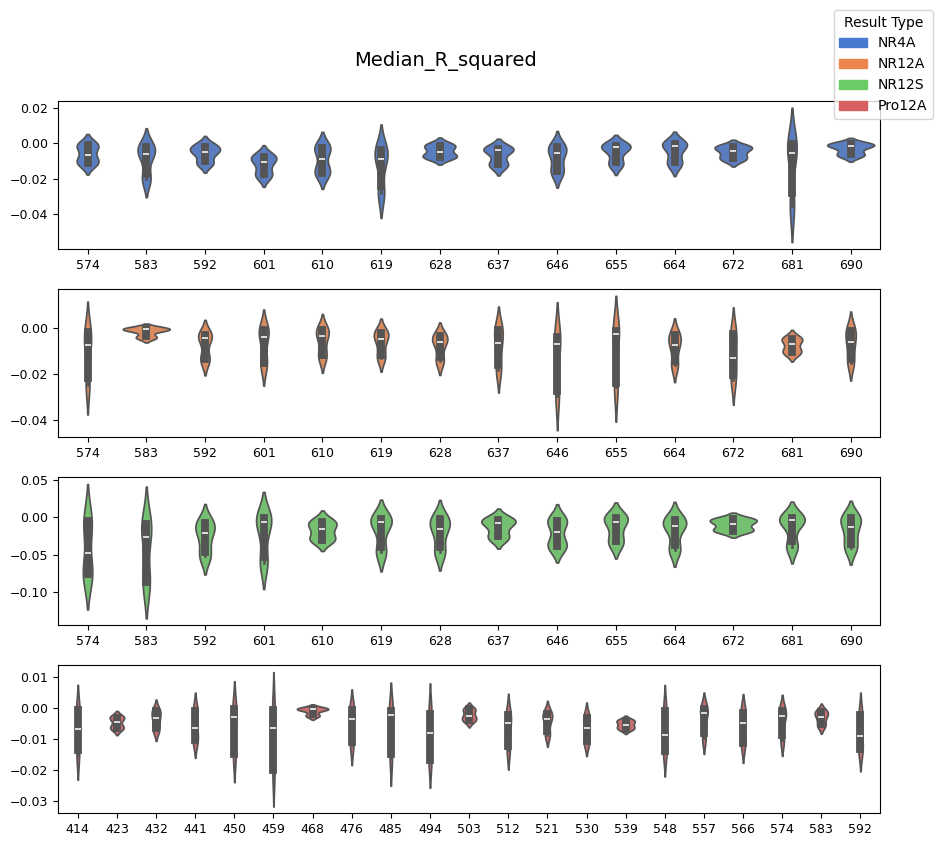

In [79]:
plot_spectral_results(results_dict, plot_columns, channels, figures_path)